In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [25]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
df = pd.read_csv("/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [27]:
# Assuming df is your DataFrame and 'Sentiment' is the column of interest
class_counts = df['Sentiment'].value_counts()

# Filter classes with count more than 12
selected_classes = class_counts[class_counts > 6].index

# Update df to set non-selected classes to 'Miscellaneous'
df.loc[~df['Sentiment'].isin(selected_classes), 'Sentiment'] = 'Miscellaneous'

In [28]:
df['Sentiment'].unique()

array([' Positive  ', 'Miscellaneous', ' Excitement ', ' Loneliness ',
       ' Contentment ', ' Hopeful ', ' Curiosity ', ' Joy ',
       ' Gratitude ', ' Embarrassed ', ' Sad ', ' Neutral ', ' Happy '],
      dtype=object)

In [29]:
df['Sentiment'].value_counts()

Sentiment
Miscellaneous    522
 Positive         44
 Joy              42
 Excitement       32
 Contentment      14
 Neutral          14
 Happy            14
 Hopeful           9
 Gratitude         9
 Sad               9
 Curiosity         8
 Embarrassed       8
 Loneliness        7
Name: count, dtype: int64

In [34]:
import pandas as pd

# Create a dictionary to map the class names to integers
class_to_int = {
" Positive  ":0,
    " Excitement ":1, 
    " Contentment ":2,
    " Joy ":3, 
    " Neutral ":4, 
    " Happy ":5,
    "Miscellaneous":6,
    " Hopeful ":7,
    " Gratitude ":8,
    " Sad ":9,
    " Loneliness ":10,
    " Embarrassed ":11,
    " Curiosity ":12
}

# Replace the class names in the DataFrame
df['Sentiment'] = df['Sentiment'].replace(class_to_int)



In [35]:
df['Sentiment'].value_counts()

Sentiment
6     522
0      44
3      42
1      32
2      14
4      14
5      14
7       9
8       9
9       9
12      8
11      8
10      7
Name: count, dtype: int64

In [42]:
class_names = [" Positive  "," Excitement ", " Contentment "," Joy ", " Neutral ", " Happy "," Hopeful ", 
               " Gratitude "," Sad ", " Loneliness ", " Embarrassed "," Curiosity "]


In [43]:
# Assuming 'Sentiment' is the name of the column in your DataFrame
df1 = df[df['Sentiment'] != 6]

In [44]:
df1['Sentiment'] .value_counts()

Sentiment
0     44
3     42
1     32
2     14
4     14
5     14
7      9
8      9
9      9
12     8
11     8
10     7
Name: count, dtype: int64

# Data Distribution

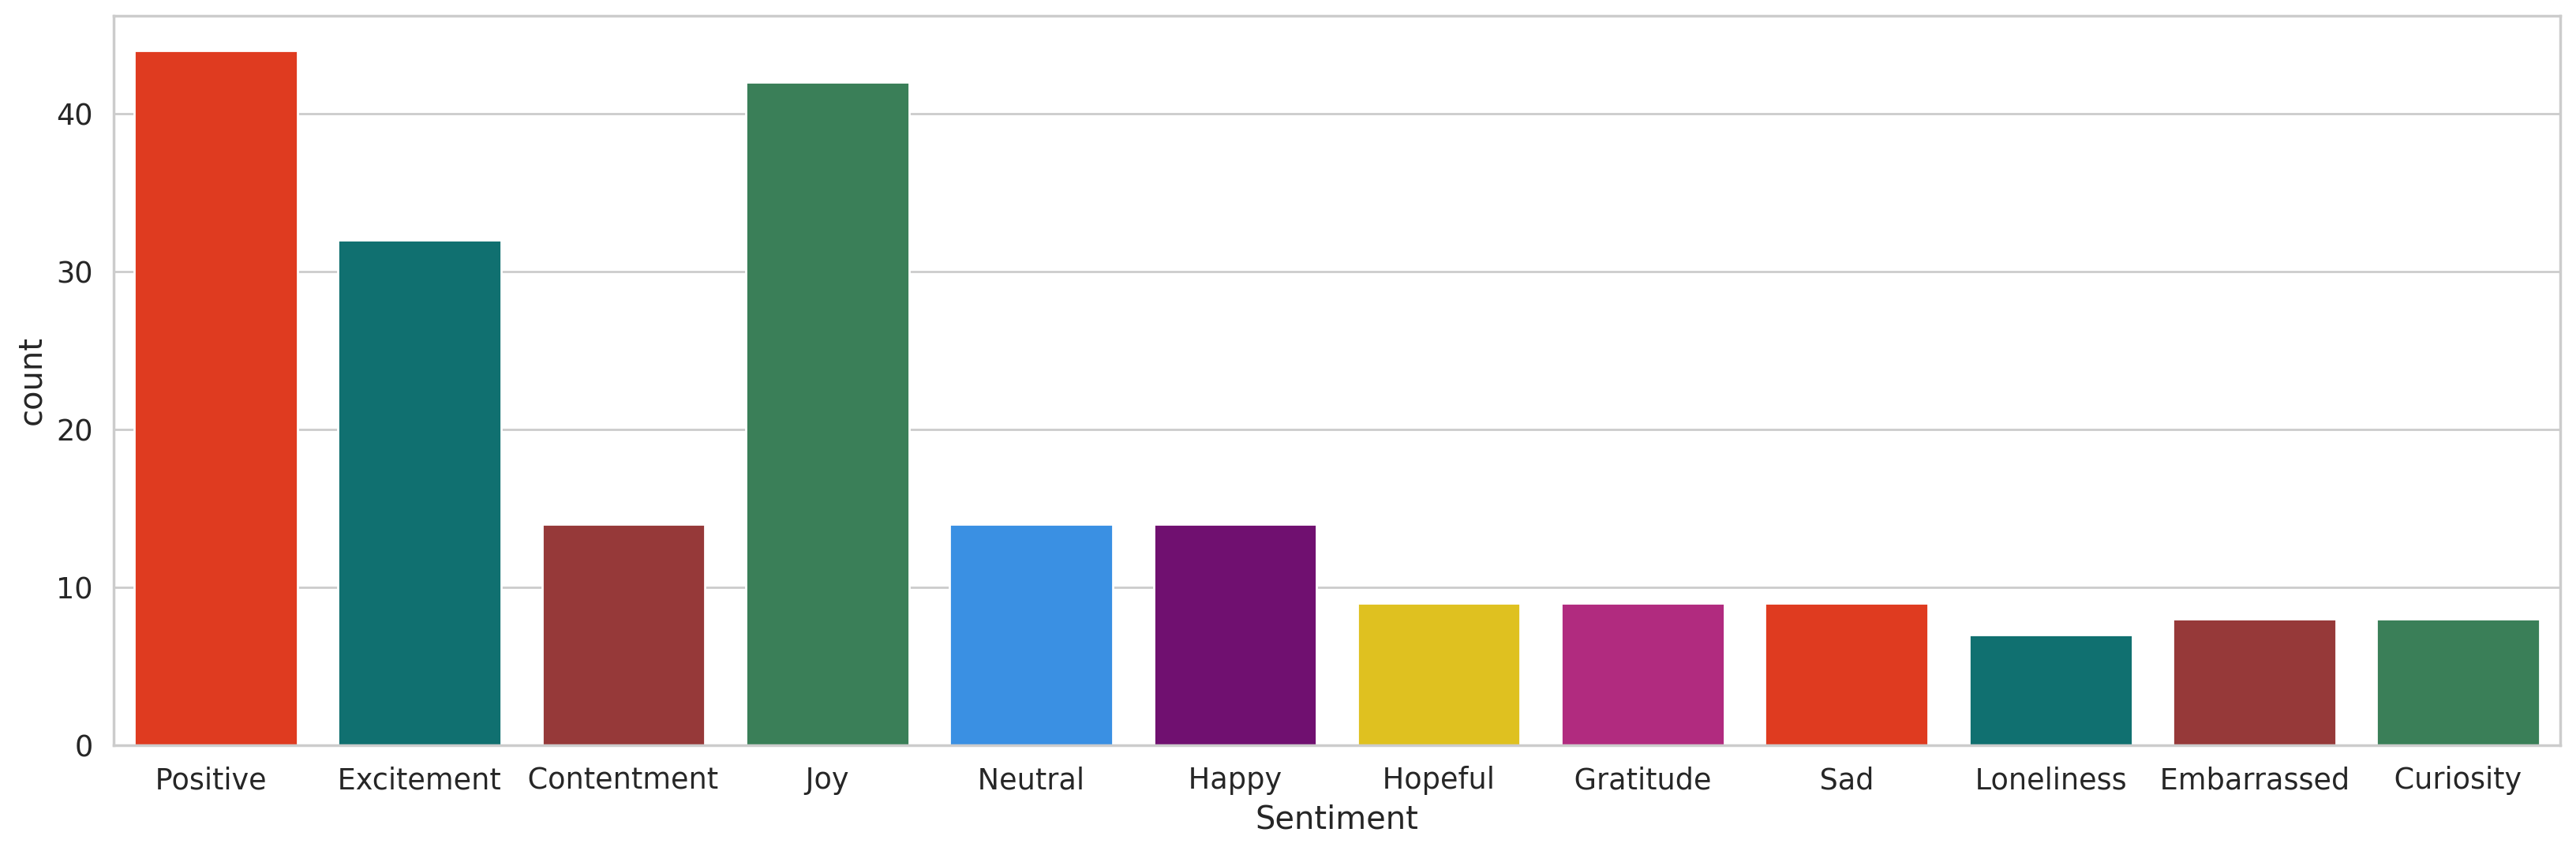

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(20, 6))

custom_palette = ['#FF2400', 'teal', '#A52A2A', 'Seagreen', 'Dodgerblue', 'Purple', 'Gold', 'MediumVioletRed']

sns.countplot(x='Sentiment', data=df1, palette=custom_palette)
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()


In [47]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def visualize_text_length(data, title):

    data['text_length'] = data['Text'].apply(len)

    plt.figure(figsize=(8, 4))

    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    plt.hist(data['text_length'], bins=40, color='lightcoral', edgecolor='black', alpha=0.7, label='Bangla News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Text Length", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')

    plt.title(f'Text Length Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Show the plot
    plt.show()




# Text Length

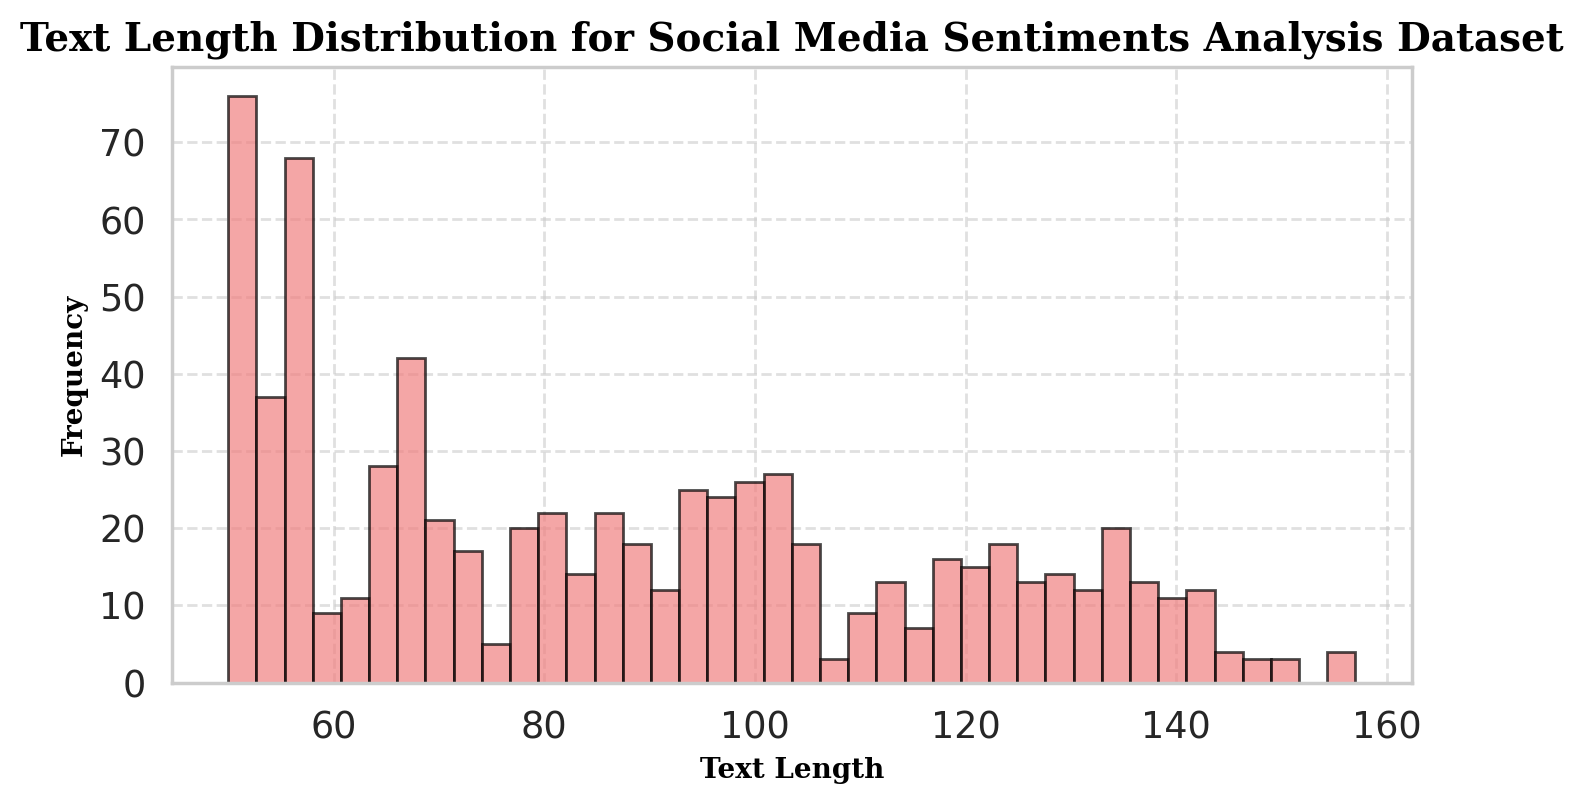

In [48]:
visualize_text_length(df, 'Social Media Sentiments Analysis Dataset')

In [49]:
from wordcloud import WordCloud

def create_wordcloud(data, column, title):
    # Specify a Bangla-supported font, such as "Siyam Rupali"



    #This setting disables the detection of collocations (multi-word phrases) to focus on individual words.
    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          colormap='turbo', collocations=False).generate(' '.join(data[column]))

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {column} in {title}', fontsize=16, color='black')
    plt.axis('off')
    plt.show()

# WordCloud

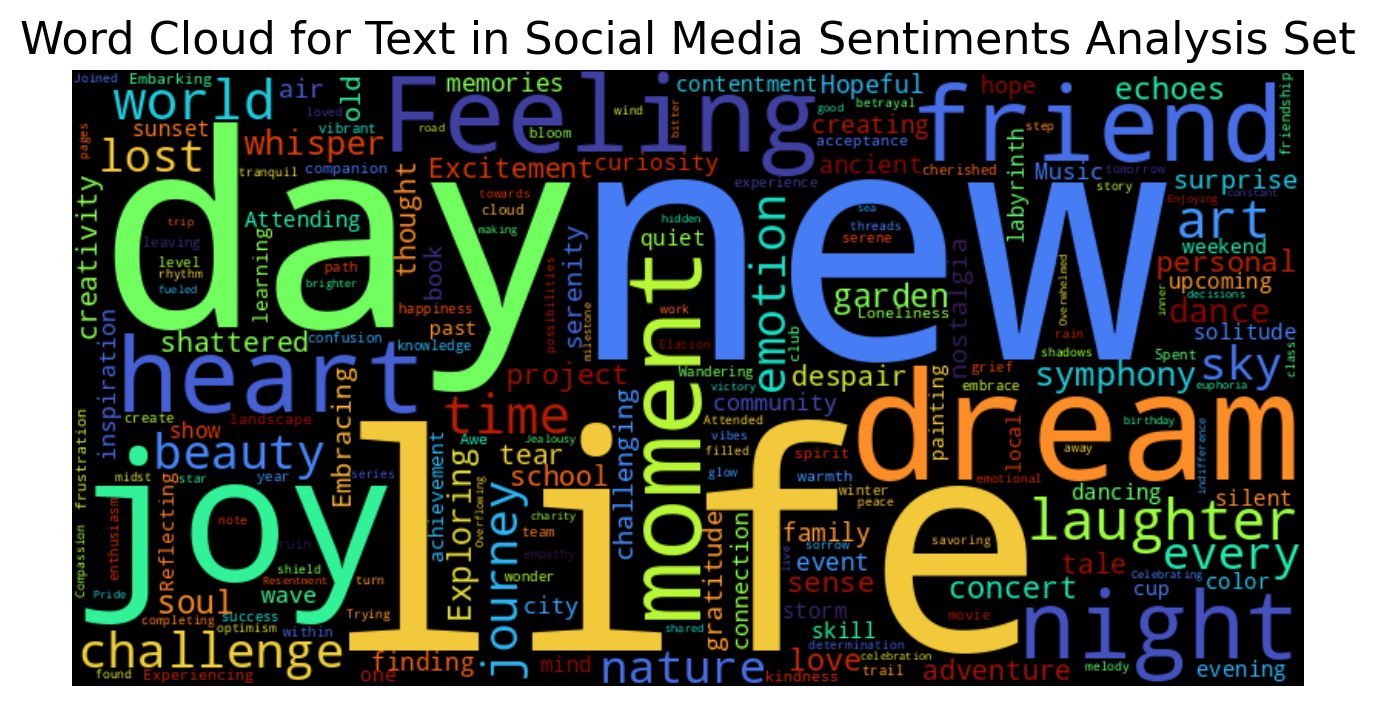

In [50]:
create_wordcloud(df, 'Text', 'Social Media Sentiments Analysis Set')

In [51]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# distilbert

In [52]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased' 

In [53]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [54]:
sample_txt = 'Enjoying a beautiful day at the park!'

In [55]:

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Enjoying a beautiful day at the park!
   Tokens: ['enjoying', 'a', 'beautiful', 'day', 'at', 'the', 'park', '!']
Token IDs: [9107, 1037, 3376, 2154, 2012, 1996, 2380, 999]


In [56]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [58]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")

In [59]:
token_lens = []

for txt in df.Text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

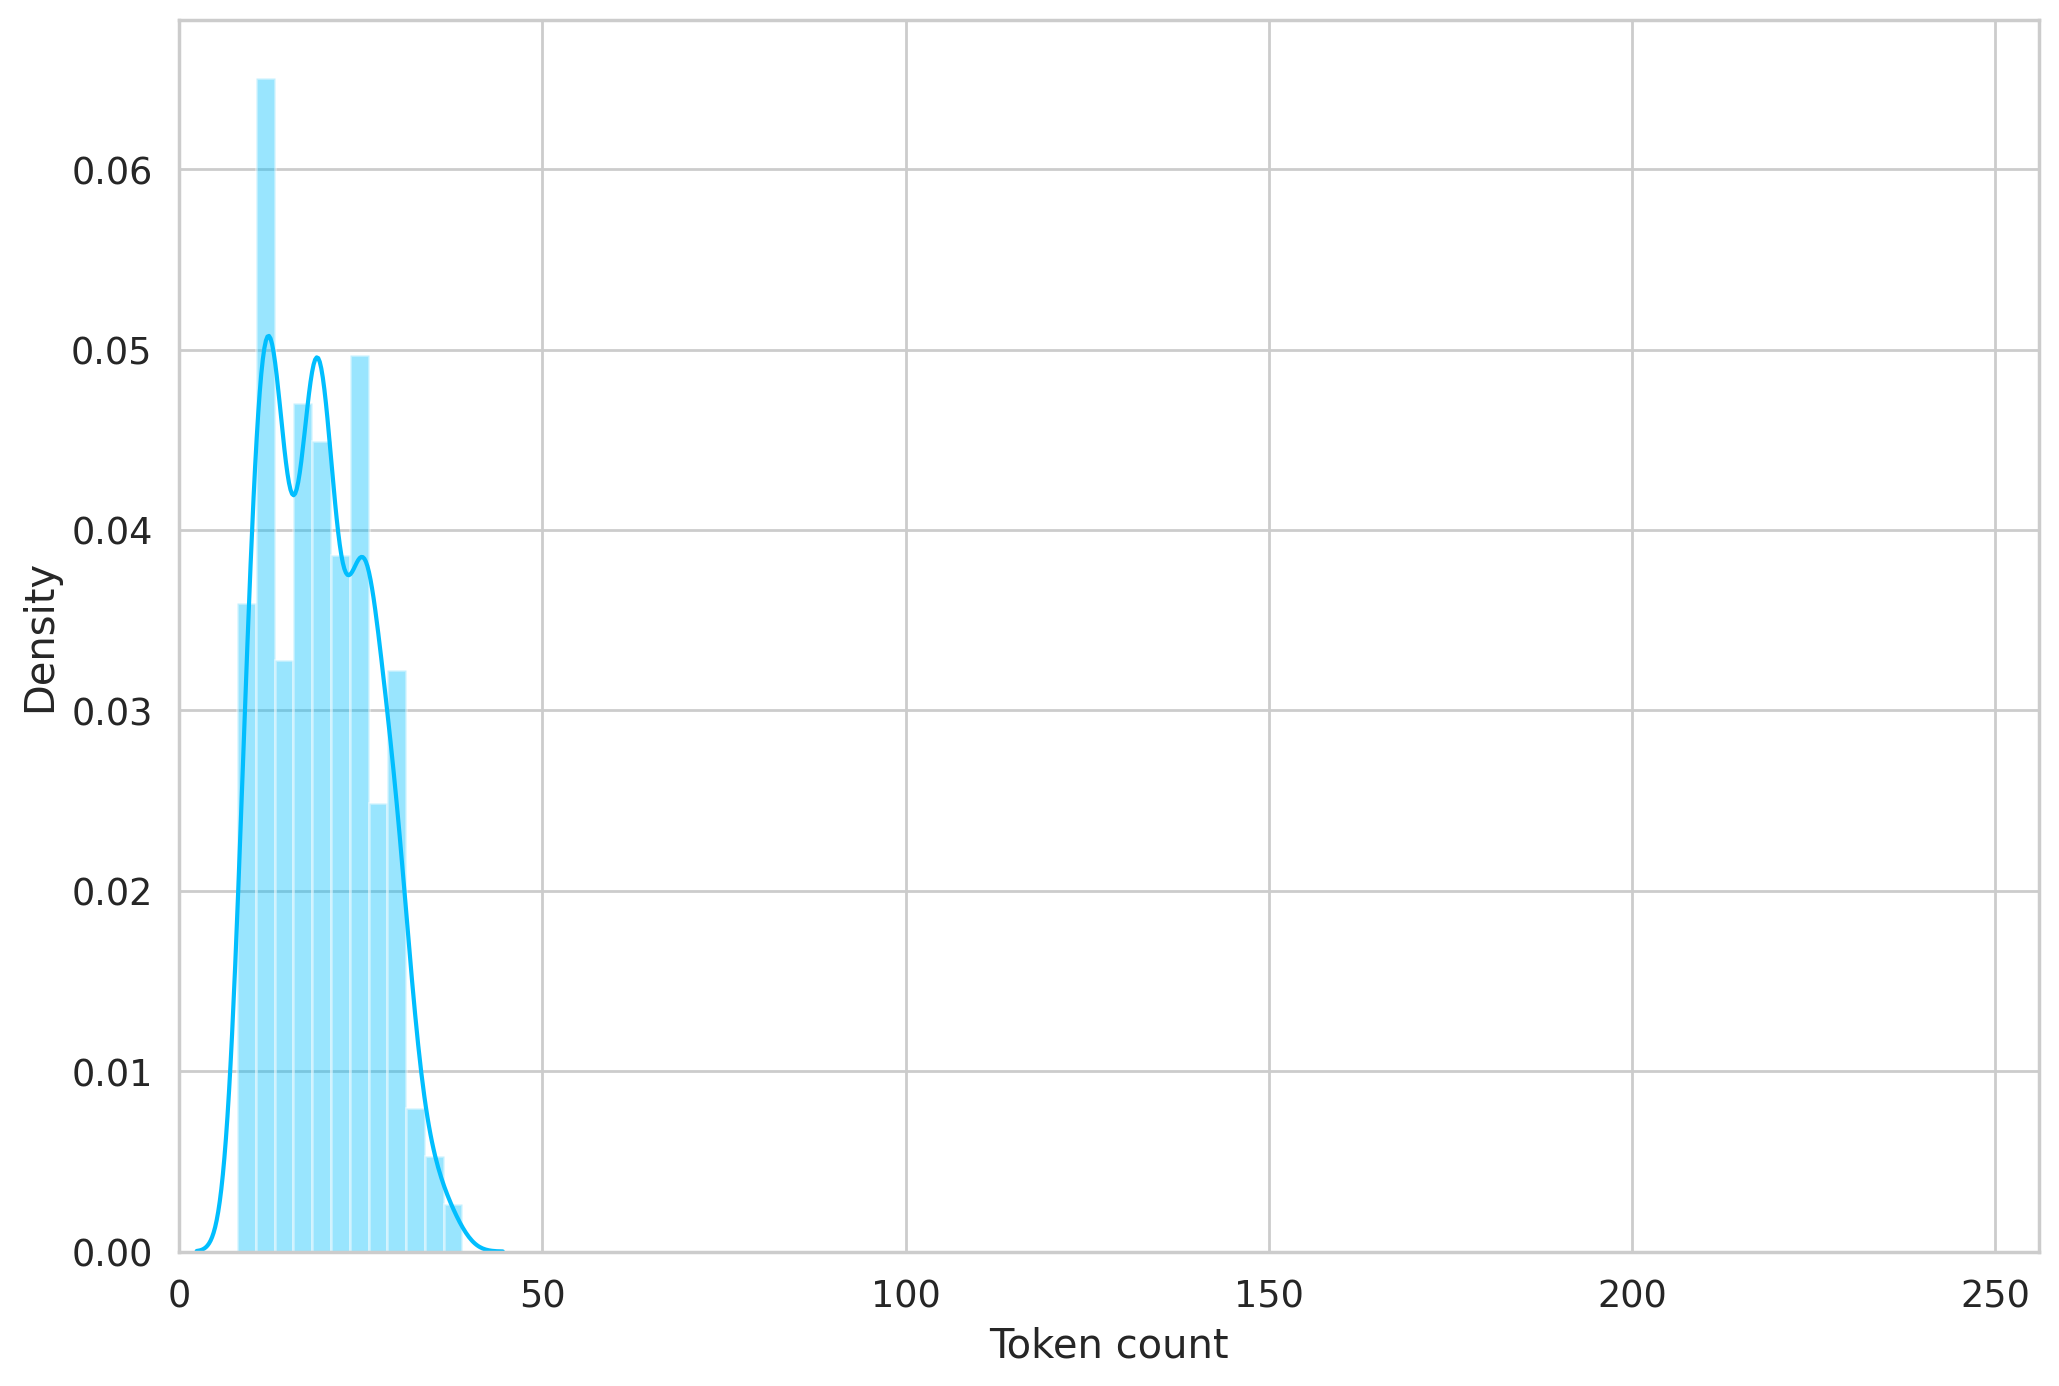

In [60]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [61]:
selected_columns = ['Text', 'Sentiment']
df = df[selected_columns]

In [62]:
MAX_LEN = 50

In [63]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [64]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [65]:
df_train.shape, df_val.shape, df_test.shape

((512, 2), (110, 2), (110, 2))

In [66]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [67]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [68]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [69]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 50])
torch.Size([8, 50])
torch.Size([8])


In [71]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

In [73]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [74]:
PRE_TRAINED_MODEL_NAME

'distilbert-base-uncased'

In [75]:
bert_model.config.hidden_size

768

# SentimentClassifier Model

In [117]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)  # model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        # Assuming logits are in the first element of the tuple
        logits = outputs[0]

        # Apply dropout and linear layer
        output = self.drop(logits)

        # Assuming you want to use the representation for the [CLS] token
        cls_representation = logits[:, 0, :]

        return self.out(cls_representation)


In [118]:
model = SentimentClassifier(13)
model = model.to(device)

In [119]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 50])
torch.Size([8, 50])


In [120]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0628, 0.0953, 0.1146, 0.0324, 0.0578, 0.0773, 0.1166, 0.0781, 0.0509,
         0.0964, 0.0835, 0.0646, 0.0696],
        [0.0814, 0.1061, 0.0966, 0.0353, 0.0717, 0.0745, 0.1110, 0.0910, 0.0433,
         0.0921, 0.0791, 0.0551, 0.0628],
        [0.0713, 0.0890, 0.0829, 0.0339, 0.0723, 0.0712, 0.1147, 0.0858, 0.0502,
         0.0975, 0.0837, 0.0740, 0.0737],
        [0.0659, 0.0892, 0.1032, 0.0311, 0.0588, 0.0764, 0.1080, 0.0861, 0.0465,
         0.1157, 0.0684, 0.0766, 0.0741],
        [0.0799, 0.0817, 0.1096, 0.0364, 0.0626, 0.0739, 0.0959, 0.0915, 0.0482,
         0.0920, 0.0700, 0.0774, 0.0810],
        [0.0795, 0.0992, 0.0906, 0.0354, 0.0689, 0.0822, 0.1085, 0.0945, 0.0431,
         0.0960, 0.0659, 0.0657, 0.0706],
        [0.0761, 0.0897, 0.0903, 0.0383, 0.0706, 0.0724, 0.1184, 0.0838, 0.0492,
         0.1005, 0.0747, 0.0664, 0.0697],
        [0.0851, 0.0875, 0.0836, 0.0346, 0.0681, 0.0694, 0.1278, 0.0846, 0.0463,
         0.0859, 0.0839, 0.0648, 0.0784]], device='cuda:0'

In [128]:
EPOCHS = 500

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [129]:
from tqdm import tqdm
import torch
import numpy as np

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].squeeze().to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [130]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Ensure targets are of type long
            targets = targets.view(-1)  # Reshape to a 1-dimensional tensor if needed
            loss = loss_fn(outputs, targets)


            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


# Training 

In [131]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.25batch/s, loss=0.21]  



Train loss 0.21027476623748953 accuracy 0.939453125


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.33batch/s, loss=1.05]



Val   loss 1.054326178772109 accuracy 0.7545454545454545

Epoch 2/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=0.179]



Train loss 0.17920259225866175 accuracy 0.947265625


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.22batch/s, loss=0.881]



Val   loss 0.8805258598710809 accuracy 0.8545454545454545

Epoch 3/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=0.0453]



Train loss 0.04529708437075897 accuracy 0.986328125


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.67batch/s, loss=0.902]



Val   loss 0.9022037269813674 accuracy 0.8181818181818181

Epoch 4/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=0.00977]



Train loss 0.009770323431439465 accuracy 0.998046875


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.82batch/s, loss=0.914]



Val   loss 0.9141770417336375 accuracy 0.8363636363636363

Epoch 5/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.62batch/s, loss=0.00454]



Train loss 0.004535002650300157 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.43batch/s, loss=0.907]



Val   loss 0.9071103405232341 accuracy 0.8363636363636363

Epoch 6/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=0.00348]



Train loss 0.003480584749922855 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.14batch/s, loss=0.927]



Val   loss 0.9268388847413007 accuracy 0.8454545454545455

Epoch 7/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.74batch/s, loss=0.00301]



Train loss 0.003009529426890367 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.00batch/s, loss=1.02] 



Val   loss 1.0158174125743764 accuracy 0.8363636363636363

Epoch 8/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=0.00251]



Train loss 0.002512183443286631 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.25batch/s, loss=0.976]



Val   loss 0.9759179891053853 accuracy 0.8363636363636363

Epoch 9/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.20batch/s, loss=0.00236]



Train loss 0.0023632015954717644 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.26batch/s, loss=1]    



Val   loss 1.0003931320305648 accuracy 0.8363636363636363

Epoch 10/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.60batch/s, loss=0.00222]



Train loss 0.0022164034153320245 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.79batch/s, loss=0.985]



Val   loss 0.9849620296154171 accuracy 0.8363636363636363

Epoch 11/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=0.00198]



Train loss 0.001984158042432682 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.39batch/s, loss=1.02]   



Val   loss 1.0220415570324153 accuracy 0.8363636363636363

Epoch 12/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=0.0018] 



Train loss 0.0017963280715775909 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.88batch/s, loss=1.02] 



Val   loss 1.0185920787501215 accuracy 0.8363636363636363

Epoch 13/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.13batch/s, loss=0.00171]



Train loss 0.001711180745587626 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.51batch/s, loss=1.04] 



Val   loss 1.036413451053834 accuracy 0.8363636363636363

Epoch 14/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=0.00155]



Train loss 0.0015540440977019898 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.29batch/s, loss=1.01]



Val   loss 1.014433581115944 accuracy 0.8363636363636363

Epoch 15/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=0.0015] 



Train loss 0.0015043244943626632 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.84batch/s, loss=1.05] 



Val   loss 1.0495624300300344 accuracy 0.8363636363636363

Epoch 16/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=0.00143]



Train loss 0.0014331018282973673 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.79batch/s, loss=1.03]   



Val   loss 1.0320440246141516 accuracy 0.8363636363636363

Epoch 17/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.88batch/s, loss=0.00134]



Train loss 0.001341374445019028 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.21batch/s, loss=1.04]



Val   loss 1.0404808461108976 accuracy 0.8363636363636363

Epoch 18/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=0.00127]



Train loss 0.001273124699764594 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.54batch/s, loss=1.05]



Val   loss 1.0476949641119322 accuracy 0.8363636363636363

Epoch 19/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.66batch/s, loss=0.0012] 



Train loss 0.001196516194340802 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.43batch/s, loss=1.06]



Val   loss 1.061122111743316 accuracy 0.8363636363636363

Epoch 20/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=0.00114]



Train loss 0.001143900361512351 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.49batch/s, loss=1.09] 



Val   loss 1.086487039441376 accuracy 0.8363636363636363

Epoch 21/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=0.00113] 



Train loss 0.0011289789631518943 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.05batch/s, loss=1.13] 



Val   loss 1.1264639946415886 accuracy 0.8363636363636363

Epoch 22/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.68batch/s, loss=0.00106] 



Train loss 0.001059048782735772 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, loss=1.09]



Val   loss 1.085291440031142 accuracy 0.8363636363636363

Epoch 23/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=0.00104] 



Train loss 0.001039925264649355 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.46batch/s, loss=1.11] 



Val   loss 1.1124445563598004 accuracy 0.8363636363636363

Epoch 24/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=0.000969]



Train loss 0.0009688274685686338 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.70batch/s, loss=1.11] 



Val   loss 1.1057475309041496 accuracy 0.8363636363636363

Epoch 25/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=0.000942]



Train loss 0.0009419245016033528 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.74batch/s, loss=1.1] 



Val   loss 1.101736993495641 accuracy 0.8363636363636363

Epoch 26/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=0.000886]



Train loss 0.0008862018939908012 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.18batch/s, loss=1.11]



Val   loss 1.10647364477232 accuracy 0.8363636363636363

Epoch 27/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=0.000868]



Train loss 0.0008677779965182708 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.90batch/s, loss=1.1]    



Val   loss 1.0965979574788693 accuracy 0.8363636363636363

Epoch 28/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.03batch/s, loss=0.00083] 



Train loss 0.0008298169132103794 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.97batch/s, loss=1.1] 



Val   loss 1.098290509827036 accuracy 0.8363636363636363

Epoch 29/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.18batch/s, loss=0.000808]



Train loss 0.0008078932628450275 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.37batch/s, loss=1.1]  



Val   loss 1.1029089789039321 accuracy 0.8363636363636363

Epoch 30/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.24batch/s, loss=0.00077] 



Train loss 0.0007704493518758682 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.86batch/s, loss=1.14] 



Val   loss 1.1382074724159403 accuracy 0.8363636363636363

Epoch 31/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.45batch/s, loss=0.000735]



Train loss 0.0007354414683504729 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.84batch/s, loss=1.16]



Val   loss 1.1608786821140842 accuracy 0.8363636363636363

Epoch 32/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=0.000712]



Train loss 0.0007122867450561898 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.81batch/s, loss=1.14]



Val   loss 1.1382498012057372 accuracy 0.8363636363636363

Epoch 33/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.60batch/s, loss=0.000719]



Train loss 0.0007189559933067358 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.31batch/s, loss=1.15] 



Val   loss 1.1460255663925116 accuracy 0.8363636363636363

Epoch 34/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=0.000671]



Train loss 0.0006712431177220424 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.24batch/s, loss=1.15]   



Val   loss 1.1469580987218901 accuracy 0.8363636363636363

Epoch 35/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.60batch/s, loss=0.000655]



Train loss 0.0006550102591518225 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.01batch/s, loss=1.13] 



Val   loss 1.1304976016971133 accuracy 0.8363636363636363

Epoch 36/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.16batch/s, loss=0.00062] 



Train loss 0.0006197109682943847 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.15batch/s, loss=1.22] 



Val   loss 1.2175954752892721 accuracy 0.8363636363636363

Epoch 37/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=0.00062] 



Train loss 0.0006197539817094366 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.10batch/s, loss=1.17]



Val   loss 1.1664482329444061 accuracy 0.8363636363636363

Epoch 38/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=0.000604]



Train loss 0.0006038603510205576 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.58batch/s, loss=1.14]   



Val   loss 1.1440412429406674 accuracy 0.8363636363636363

Epoch 39/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.19batch/s, loss=0.000565]



Train loss 0.0005646006911774748 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.29batch/s, loss=1.17]



Val   loss 1.1672355782939121 accuracy 0.8363636363636363

Epoch 40/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=0.000552]



Train loss 0.0005518221448710392 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.92batch/s, loss=1.15]  



Val   loss 1.1525642350596692 accuracy 0.8363636363636363

Epoch 41/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=0.000529]



Train loss 0.0005289773566801159 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 33.36batch/s, loss=1.19]



Val   loss 1.1903143461677246 accuracy 0.8363636363636363

Epoch 42/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.11batch/s, loss=0.000521]



Train loss 0.0005213747599555063 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.71batch/s, loss=1.19]



Val   loss 1.1914337507582136 accuracy 0.8363636363636363

Epoch 43/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.16batch/s, loss=0.000496]



Train loss 0.0004961086647199409 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.80batch/s, loss=1.19]   



Val   loss 1.1871869350351127 accuracy 0.8363636363636363

Epoch 44/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=0.000492]



Train loss 0.0004924350489545759 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.11batch/s, loss=1.17]



Val   loss 1.1682094524938813 accuracy 0.8363636363636363

Epoch 45/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=0.000475]



Train loss 0.0004752082836603222 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.14batch/s, loss=1.17]



Val   loss 1.1727198267866956 accuracy 0.8363636363636363

Epoch 46/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=0.000472]



Train loss 0.0004723341633052769 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.30batch/s, loss=1.18]



Val   loss 1.175381339965887 accuracy 0.8363636363636363

Epoch 47/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.21batch/s, loss=0.000456]



Train loss 0.00045559383283944044 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.82batch/s, loss=1.2] 



Val   loss 1.1978149097994901 accuracy 0.8363636363636363

Epoch 48/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.37batch/s, loss=0.000438]



Train loss 0.00043846626022059354 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.71batch/s, loss=1.2] 



Val   loss 1.196178159088179 accuracy 0.8363636363636363

Epoch 49/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=0.000421]



Train loss 0.0004207991962630331 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.43batch/s, loss=1.21]



Val   loss 1.2056417178454077 accuracy 0.8363636363636363

Epoch 50/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=0.000409]



Train loss 0.00040919479829426564 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.91batch/s, loss=1.19]



Val   loss 1.1937552202808936 accuracy 0.8363636363636363

Epoch 51/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.07batch/s, loss=0.000407]



Train loss 0.00040658616148903093 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.18batch/s, loss=1.22] 



Val   loss 1.2172759679555643 accuracy 0.8363636363636363

Epoch 52/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=0.000392]



Train loss 0.0003916671873867017 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.45batch/s, loss=1.23]



Val   loss 1.231291288094196 accuracy 0.8363636363636363

Epoch 53/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.73batch/s, loss=0.000381]



Train loss 0.0003810802970747318 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.57batch/s, loss=1.3]  



Val   loss 1.300030162537171 accuracy 0.8363636363636363

Epoch 54/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.83batch/s, loss=0.000374]



Train loss 0.00037373562145148753 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.39batch/s, loss=1.24]



Val   loss 1.2387477277131569 accuracy 0.8363636363636363

Epoch 55/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=0.000358]



Train loss 0.00035845095567310636 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.48batch/s, loss=1.21]



Val   loss 1.208668957474791 accuracy 0.8363636363636363

Epoch 56/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.73batch/s, loss=0.000348]



Train loss 0.0003481474178670396 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.95batch/s, loss=1.21]



Val   loss 1.2119336490967336 accuracy 0.8363636363636363

Epoch 57/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=0.000341]



Train loss 0.0003406292902354835 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.08batch/s, loss=1.22]



Val   loss 1.2166375544371217 accuracy 0.8363636363636363

Epoch 58/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.72batch/s, loss=0.000333]



Train loss 0.0003326838532302645 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.36batch/s, loss=1.22]



Val   loss 1.2203113379411141 accuracy 0.8363636363636363

Epoch 59/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=0.000321]



Train loss 0.00032079311472443806 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.22batch/s, loss=1.27]   



Val   loss 1.2660809305842642 accuracy 0.8454545454545455

Epoch 60/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.66batch/s, loss=0.000317]



Train loss 0.00031694339941168437 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.99batch/s, loss=1.3]    



Val   loss 1.295937759682212 accuracy 0.8454545454545455

Epoch 61/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.65batch/s, loss=0.000315]



Train loss 0.00031465358893001394 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.34batch/s, loss=1.29]



Val   loss 1.289315781895961 accuracy 0.8454545454545455

Epoch 62/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.35batch/s, loss=0.000301]



Train loss 0.00030074556138970365 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.87batch/s, loss=1.23]   



Val   loss 1.234046739900285 accuracy 0.8454545454545455

Epoch 63/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=0.00029] 



Train loss 0.0002896372028544647 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.94batch/s, loss=1.29]



Val   loss 1.2908986585254232 accuracy 0.8454545454545455

Epoch 64/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=0.000286]



Train loss 0.00028561910391999845 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.10batch/s, loss=1.27]



Val   loss 1.265537846962356 accuracy 0.8454545454545455

Epoch 65/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=0.000281]



Train loss 0.00028144615498604253 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.66batch/s, loss=1.27]



Val   loss 1.2683763165940556 accuracy 0.8454545454545455

Epoch 66/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.60batch/s, loss=0.000275]



Train loss 0.00027483956398555165 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.19batch/s, loss=1.28]



Val   loss 1.275430444410761 accuracy 0.8454545454545455

Epoch 67/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=0.000263]



Train loss 0.00026333465018524294 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.67batch/s, loss=1.25]



Val   loss 1.252146331651602 accuracy 0.8363636363636363

Epoch 68/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=0.000257]



Train loss 0.00025701797653709946 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.33batch/s, loss=1.34]



Val   loss 1.3361683180295845 accuracy 0.8454545454545455

Epoch 69/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.59batch/s, loss=0.000248]



Train loss 0.0002476228681871362 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.33batch/s, loss=1.29]



Val   loss 1.2908594905456994 accuracy 0.8454545454545455

Epoch 70/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=0.000244]



Train loss 0.00024424252808330493 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.48batch/s, loss=1.29]



Val   loss 1.2932139404438203 accuracy 0.8454545454545455

Epoch 71/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.71batch/s, loss=0.000244]



Train loss 0.00024391349700181308 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.54batch/s, loss=1.29]



Val   loss 1.2948369087264706 accuracy 0.8454545454545455

Epoch 72/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=0.000229]



Train loss 0.00022916465832167887 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.62batch/s, loss=1.29]



Val   loss 1.2922365902548856 accuracy 0.8454545454545455

Epoch 73/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.72batch/s, loss=0.000229]



Train loss 0.00022914894520909002 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, loss=1.29]   



Val   loss 1.2908853331266852 accuracy 0.8454545454545455

Epoch 74/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.71batch/s, loss=0.000225]



Train loss 0.000224945069817295 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.74batch/s, loss=1.27] 



Val   loss 1.2714926830189401 accuracy 0.8454545454545455

Epoch 75/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=0.000215]



Train loss 0.00021538069734106102 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.69batch/s, loss=1.27]



Val   loss 1.274872669256313 accuracy 0.8454545454545455

Epoch 76/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.65batch/s, loss=0.000214]



Train loss 0.00021438590124489565 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.83batch/s, loss=1.28]



Val   loss 1.282933160691755 accuracy 0.8454545454545455

Epoch 77/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=0.00021] 



Train loss 0.00020957354547590512 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.13batch/s, loss=1.35]



Val   loss 1.3512840608008057 accuracy 0.8454545454545455

Epoch 78/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.66batch/s, loss=0.000205]



Train loss 0.0002047044054052094 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.07batch/s, loss=1.32]   



Val   loss 1.317152193883885 accuracy 0.8454545454545455

Epoch 79/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=0.000196]



Train loss 0.00019610497042776842 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.11batch/s, loss=1.31]   



Val   loss 1.3097327802476815 accuracy 0.8454545454545455

Epoch 80/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=0.000196]



Train loss 0.000196427400965149 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.30batch/s, loss=1.29]



Val   loss 1.2921761830304084 accuracy 0.8454545454545455

Epoch 81/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=0.000191]



Train loss 0.00019128150847791403 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.13batch/s, loss=1.29]  



Val   loss 1.2919391818156458 accuracy 0.8454545454545455

Epoch 82/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.17batch/s, loss=0.000183]



Train loss 0.00018300100043688872 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.86batch/s, loss=1.3]    



Val   loss 1.295377753005076 accuracy 0.8454545454545455

Epoch 83/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.64batch/s, loss=0.000182]



Train loss 0.00018219462594970537 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.98batch/s, loss=1.3] 



Val   loss 1.2994419025406907 accuracy 0.8363636363636363

Epoch 84/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=0.000175]



Train loss 0.00017518915916525657 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.21batch/s, loss=1.36]



Val   loss 1.3566446906001406 accuracy 0.8363636363636363

Epoch 85/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=0.000172]



Train loss 0.00017150616002936658 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.19batch/s, loss=1.3] 



Val   loss 1.3044550836610662 accuracy 0.8363636363636363

Epoch 86/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=0.000171]



Train loss 0.0001705364326767267 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.41batch/s, loss=1.35]



Val   loss 1.3476878880662428 accuracy 0.8363636363636363

Epoch 87/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=0.000163]



Train loss 0.0001628937594659874 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.35batch/s, loss=1.31]  



Val   loss 1.3107525216504914 accuracy 0.8363636363636363

Epoch 88/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=0.000157]



Train loss 0.00015661969086977479 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.47batch/s, loss=1.37]   



Val   loss 1.3712194876640882 accuracy 0.8363636363636363

Epoch 89/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.19batch/s, loss=0.000158]



Train loss 0.00015841903064028884 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.93batch/s, loss=1.35]



Val   loss 1.3532197919916402 accuracy 0.8363636363636363

Epoch 90/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.29batch/s, loss=0.000153]



Train loss 0.00015278243319016838 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.10batch/s, loss=1.38]



Val   loss 1.378428721905428 accuracy 0.8363636363636363

Epoch 91/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=0.000151]



Train loss 0.00015098335268248775 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.98batch/s, loss=1.37]



Val   loss 1.3678064618896835 accuracy 0.8363636363636363

Epoch 92/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=0.000145]



Train loss 0.00014510592143324175 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.97batch/s, loss=1.33]   



Val   loss 1.3264590640568972 accuracy 0.8363636363636363

Epoch 93/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.45batch/s, loss=0.000144]



Train loss 0.00014358411738157884 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.20batch/s, loss=1.33]



Val   loss 1.329571754151922 accuracy 0.8363636363636363

Epoch 94/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=0.00014] 



Train loss 0.00013999722079915955 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.08batch/s, loss=1.37]



Val   loss 1.3706588291042863 accuracy 0.8363636363636363

Epoch 95/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.71batch/s, loss=0.000137]



Train loss 0.0001368676630590926 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.05batch/s, loss=1.36]  



Val   loss 1.3649303846928629 accuracy 0.8363636363636363

Epoch 96/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=0.000132]



Train loss 0.0001320863535170247 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.12batch/s, loss=1.38]



Val   loss 1.3759059255992594 accuracy 0.8363636363636363

Epoch 97/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.17batch/s, loss=0.000132]



Train loss 0.00013196958713024287 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.85batch/s, loss=1.34]



Val   loss 1.342821869789207 accuracy 0.8363636363636363

Epoch 98/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.60batch/s, loss=0.000125]



Train loss 0.0001250084998218881 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.78batch/s, loss=1.39]  



Val   loss 1.3856096348944058 accuracy 0.8363636363636363

Epoch 99/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=0.000122]



Train loss 0.00012228760022026108 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.84batch/s, loss=1.37]



Val   loss 1.3730127296119983 accuracy 0.8363636363636363

Epoch 100/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.68batch/s, loss=0.00012] 



Train loss 0.00012002230994312413 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.87batch/s, loss=1.38]   



Val   loss 1.3768906455557695 accuracy 0.8363636363636363

Epoch 101/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=0.000116]



Train loss 0.00011630967838982542 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.17batch/s, loss=1.39]



Val   loss 1.3910879098761402 accuracy 0.8363636363636363

Epoch 102/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.04batch/s, loss=0.000115]



Train loss 0.00011519578526986152 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.26batch/s, loss=1.36]



Val   loss 1.3632227624283197 accuracy 0.8454545454545455

Epoch 103/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=0.000113]



Train loss 0.00011260119606504304 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.33batch/s, loss=1.36]  



Val   loss 1.3630286327398997 accuracy 0.8454545454545455

Epoch 104/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=0.000112]



Train loss 0.00011192395265879895 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.29batch/s, loss=1.37]   



Val   loss 1.3690037591628166 accuracy 0.8454545454545455

Epoch 105/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=0.000107]



Train loss 0.00010718072394411138 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.47batch/s, loss=1.37]



Val   loss 1.37128605475287 accuracy 0.8454545454545455

Epoch 106/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=0.000105]



Train loss 0.00010520621816567655 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.52batch/s, loss=1.38]



Val   loss 1.3757437340569336 accuracy 0.8454545454545455

Epoch 107/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.60batch/s, loss=0.000102]



Train loss 0.00010166848323933664 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.84batch/s, loss=1.4] 



Val   loss 1.3968417341046526 accuracy 0.8454545454545455

Epoch 108/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.02batch/s, loss=0.000101]



Train loss 0.00010116571530716101 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.12batch/s, loss=1.45]



Val   loss 1.446699796687426 accuracy 0.8454545454545455

Epoch 109/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.23batch/s, loss=9.79e-5] 



Train loss 9.792813557396585e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.20batch/s, loss=1.43]  



Val   loss 1.4300267274910377 accuracy 0.8454545454545455

Epoch 110/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.45batch/s, loss=9.69e-5]



Train loss 9.690123144423524e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.02batch/s, loss=1.39]



Val   loss 1.3900840496254594 accuracy 0.8454545454545455

Epoch 111/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=9.39e-5] 



Train loss 9.389997242692516e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.12batch/s, loss=1.43]



Val   loss 1.426969407510634 accuracy 0.8454545454545455

Epoch 112/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.02batch/s, loss=9.19e-5]



Train loss 9.188051717501367e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.94batch/s, loss=1.39]



Val   loss 1.3923337708091432 accuracy 0.8454545454545455

Epoch 113/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=8.87e-5]



Train loss 8.87267179052742e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.41batch/s, loss=1.42]



Val   loss 1.4163833251550386 accuracy 0.8454545454545455

Epoch 114/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.71batch/s, loss=8.67e-5]



Train loss 8.667030613196403e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.36batch/s, loss=1.47]



Val   loss 1.472253438847734 accuracy 0.8454545454545455

Epoch 115/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.71batch/s, loss=8.7e-5] 



Train loss 8.697663784573706e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.75batch/s, loss=1.42]



Val   loss 1.423749252786625 accuracy 0.8454545454545455

Epoch 116/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.28batch/s, loss=8.3e-5] 



Train loss 8.302052773956348e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.92batch/s, loss=1.44]



Val   loss 1.4388830856883683 accuracy 0.8454545454545455

Epoch 117/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=8.19e-5]



Train loss 8.192033041609648e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.30batch/s, loss=1.46]



Val   loss 1.4605517172019193 accuracy 0.8454545454545455

Epoch 118/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.24batch/s, loss=8.01e-5]



Train loss 8.007011425092969e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.70batch/s, loss=1.45]



Val   loss 1.4542185096708116 accuracy 0.8454545454545455

Epoch 119/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=7.79e-5]



Train loss 7.785300215346069e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.37batch/s, loss=1.47]



Val   loss 1.4743382924945243 accuracy 0.8454545454545455

Epoch 120/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 26.31batch/s, loss=7.61e-5]



Train loss 7.611501251858499e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.21batch/s, loss=1.41]  



Val   loss 1.4146429620050185 accuracy 0.8454545454545455

Epoch 121/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=7.43e-5]



Train loss 7.425510602843133e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.36batch/s, loss=1.42]



Val   loss 1.417921337740024 accuracy 0.8454545454545455

Epoch 122/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=7.42e-5]



Train loss 7.4156915701451e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.32batch/s, loss=1.45]



Val   loss 1.4528568822227368 accuracy 0.8454545454545455

Epoch 123/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=7.05e-5]



Train loss 7.054049689259045e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.56batch/s, loss=1.5]    



Val   loss 1.5018033184960586 accuracy 0.8454545454545455

Epoch 124/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.17batch/s, loss=6.9e-5] 



Train loss 6.904157109488551e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.02batch/s, loss=1.43]



Val   loss 1.4267331323907066 accuracy 0.8454545454545455

Epoch 125/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=6.71e-5]



Train loss 6.71099191436042e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.52batch/s, loss=1.45]



Val   loss 1.45212341388885 accuracy 0.8454545454545455

Epoch 126/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.09batch/s, loss=6.61e-5]



Train loss 6.610235305970491e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.11batch/s, loss=1.54]



Val   loss 1.538503528389096 accuracy 0.8454545454545455

Epoch 127/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=6.57e-5]



Train loss 6.571678349587273e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.09batch/s, loss=1.47]  



Val   loss 1.4747566657867668 accuracy 0.8454545454545455

Epoch 128/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=6.26e-5]



Train loss 6.256873086840642e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.68batch/s, loss=1.44]



Val   loss 1.444368809722229 accuracy 0.8454545454545455

Epoch 129/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=6.14e-5]



Train loss 6.14161547787262e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.71batch/s, loss=1.44]



Val   loss 1.4402239866785749 accuracy 0.8454545454545455

Epoch 130/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.64batch/s, loss=6.07e-5]



Train loss 6.073324169619809e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.48batch/s, loss=1.44]



Val   loss 1.4431027534255918 accuracy 0.8454545454545455

Epoch 131/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=5.95e-5]



Train loss 5.954752725756407e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.73batch/s, loss=1.45]



Val   loss 1.4494624548432122 accuracy 0.8454545454545455

Epoch 132/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=5.76e-5]



Train loss 5.75526007935423e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.72batch/s, loss=1.47]  



Val   loss 1.4706744321993028 accuracy 0.8454545454545455

Epoch 133/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=5.66e-5]



Train loss 5.658546135123288e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.35batch/s, loss=1.47]



Val   loss 1.4733043700299018 accuracy 0.8454545454545455

Epoch 134/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.60batch/s, loss=5.54e-5]



Train loss 5.536087869018047e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.91batch/s, loss=1.46]



Val   loss 1.4641106697432147 accuracy 0.8454545454545455

Epoch 135/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=5.38e-5]



Train loss 5.3807034603892134e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.27batch/s, loss=1.49]  



Val   loss 1.4877557071132677 accuracy 0.8454545454545455

Epoch 136/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=5.32e-5]



Train loss 5.316216375206295e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.26batch/s, loss=1.49]



Val   loss 1.49209242226373 accuracy 0.8454545454545455

Epoch 137/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.65batch/s, loss=5.09e-5]



Train loss 5.0903096052934416e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.22batch/s, loss=1.54]



Val   loss 1.5372650471076017 accuracy 0.8454545454545455

Epoch 138/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.75batch/s, loss=4.99e-5]



Train loss 4.992278982740572e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.03batch/s, loss=1.62]   



Val   loss 1.623213775689562 accuracy 0.8454545454545455

Epoch 139/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.97batch/s, loss=4.98e-5]



Train loss 4.9769469384841614e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.81batch/s, loss=1.52]



Val   loss 1.5185261378379178 accuracy 0.8454545454545455

Epoch 140/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.59batch/s, loss=4.9e-5] 



Train loss 4.9034025749961074e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.44batch/s, loss=1.48]



Val   loss 1.4837274462838 accuracy 0.8454545454545455

Epoch 141/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=4.63e-5]



Train loss 4.6331817742384374e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.31batch/s, loss=1.49]



Val   loss 1.4923766690560245 accuracy 0.8454545454545455

Epoch 142/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=4.58e-5]



Train loss 4.577540191519347e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.53batch/s, loss=1.49]   



Val   loss 1.4875426313057167 accuracy 0.8454545454545455

Epoch 143/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=4.44e-5]



Train loss 4.442893678913151e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.10batch/s, loss=1.49]  



Val   loss 1.4923873099848737 accuracy 0.8454545454545455

Epoch 144/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=4.56e-5]



Train loss 4.5578250549738186e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.54batch/s, loss=1.49]  



Val   loss 1.491531246528861 accuracy 0.8454545454545455

Epoch 145/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=4.22e-5]



Train loss 4.221698968365217e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.53batch/s, loss=1.49]



Val   loss 1.4936793544298521 accuracy 0.8454545454545455

Epoch 146/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=4.1e-5] 



Train loss 4.101625758323735e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.42batch/s, loss=1.5] 



Val   loss 1.4978140325066696 accuracy 0.8454545454545455

Epoch 147/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.21batch/s, loss=4.04e-5]



Train loss 4.0421636356313684e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.68batch/s, loss=1.57]



Val   loss 1.5677290980209884 accuracy 0.8454545454545455

Epoch 148/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.14batch/s, loss=3.96e-5]



Train loss 3.964476509565884e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.95batch/s, loss=1.55]



Val   loss 1.546734162278751 accuracy 0.8454545454545455

Epoch 149/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=3.92e-5]



Train loss 3.9225217349780905e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.44batch/s, loss=1.51]  



Val   loss 1.5137828109771883 accuracy 0.8454545454545455

Epoch 150/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.78batch/s, loss=3.83e-5]



Train loss 3.826278097562863e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.39batch/s, loss=1.55]



Val   loss 1.5460936669265462 accuracy 0.8454545454545455

Epoch 151/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.94batch/s, loss=3.68e-5]



Train loss 3.679849716320405e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.30batch/s, loss=1.54]  



Val   loss 1.5448795429173126 accuracy 0.8454545454545455

Epoch 152/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=3.64e-5]



Train loss 3.636616628455158e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.11batch/s, loss=1.56]



Val   loss 1.5614928070825564 accuracy 0.8454545454545455

Epoch 153/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=3.63e-5]



Train loss 3.625735938328489e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.58batch/s, loss=1.53]



Val   loss 1.526274341163766 accuracy 0.8454545454545455

Epoch 154/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.18batch/s, loss=3.52e-5]



Train loss 3.5166241914907914e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.57batch/s, loss=1.56]



Val   loss 1.5555339275063358 accuracy 0.8454545454545455

Epoch 155/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=3.38e-5]



Train loss 3.376453531700463e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.50batch/s, loss=1.54]



Val   loss 1.5394612936660386 accuracy 0.8454545454545455

Epoch 156/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.23batch/s, loss=3.28e-5]



Train loss 3.27732485203569e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.00batch/s, loss=1.53]



Val   loss 1.5329040929954252 accuracy 0.8454545454545455

Epoch 157/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.97batch/s, loss=3.23e-5]



Train loss 3.227316835818783e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.92batch/s, loss=1.58]



Val   loss 1.576374641833354 accuracy 0.8454545454545455

Epoch 158/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.19batch/s, loss=3.13e-5]



Train loss 3.127048631768048e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.45batch/s, loss=1.61]



Val   loss 1.6081753064801367 accuracy 0.8454545454545455

Epoch 159/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=3.05e-5]



Train loss 3.0475418583364444e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.80batch/s, loss=1.59]



Val   loss 1.5856750053213935 accuracy 0.8454545454545455

Epoch 160/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=3.06e-5]



Train loss 3.057805382411516e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.21batch/s, loss=1.55]



Val   loss 1.5504683834116284 accuracy 0.8454545454545455

Epoch 161/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.72batch/s, loss=2.96e-5]



Train loss 2.9559755219565886e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.48batch/s, loss=1.55]



Val   loss 1.5483571806325926 accuracy 0.8454545454545455

Epoch 162/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.14batch/s, loss=2.89e-5]



Train loss 2.890512197240014e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.18batch/s, loss=1.58]



Val   loss 1.5804895315256675 accuracy 0.8454545454545455

Epoch 163/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=2.81e-5]



Train loss 2.8096072874461697e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.96batch/s, loss=1.63]



Val   loss 1.6321185304217838 accuracy 0.8454545454545455

Epoch 164/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.66batch/s, loss=2.76e-5]



Train loss 2.7585494294157797e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.18batch/s, loss=1.56]



Val   loss 1.5579456182859823 accuracy 0.8454545454545455

Epoch 165/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.60batch/s, loss=2.68e-5]



Train loss 2.6801417213562218e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.61batch/s, loss=1.59]



Val   loss 1.5923761272447987 accuracy 0.8454545454545455

Epoch 166/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.10batch/s, loss=2.6e-5] 



Train loss 2.6023334854130553e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.95batch/s, loss=1.59] 



Val   loss 1.5853904304741653 accuracy 0.8454545454545455

Epoch 167/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=2.56e-5]



Train loss 2.5600339405684736e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.55batch/s, loss=1.59]



Val   loss 1.5911497481777457 accuracy 0.8454545454545455

Epoch 168/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=2.48e-5]



Train loss 2.4806920713160707e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.20batch/s, loss=1.59]



Val   loss 1.5945246713525714 accuracy 0.8454545454545455

Epoch 169/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.13batch/s, loss=2.47e-5]



Train loss 2.4723758890843328e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.82batch/s, loss=1.58]



Val   loss 1.579967735705915 accuracy 0.8454545454545455

Epoch 170/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.72batch/s, loss=2.43e-5]



Train loss 2.4262730605073557e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.77batch/s, loss=1.61]



Val   loss 1.6063573373263094 accuracy 0.8454545454545455

Epoch 171/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=2.32e-5]



Train loss 2.3183736907128605e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.62batch/s, loss=1.62] 



Val   loss 1.615625244574403 accuracy 0.8454545454545455

Epoch 172/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=2.25e-5]



Train loss 2.251158151977961e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.97batch/s, loss=1.63]



Val   loss 1.6323745874893316 accuracy 0.8454545454545455

Epoch 173/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.32batch/s, loss=2.25e-5]



Train loss 2.2464558504964316e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.76batch/s, loss=1.59]



Val   loss 1.5920168963929038 accuracy 0.8454545454545455

Epoch 174/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=2.15e-5]



Train loss 2.1492543332612968e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.01batch/s, loss=1.6]    



Val   loss 1.5958610823760506 accuracy 0.8454545454545455

Epoch 175/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.79batch/s, loss=2.09e-5]



Train loss 2.0938000346859553e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.64batch/s, loss=1.65]  



Val   loss 1.6511345976975593 accuracy 0.8454545454545455

Epoch 176/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=2.04e-5]



Train loss 2.035035550562725e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.71batch/s, loss=1.65]



Val   loss 1.6454213992577544 accuracy 0.8454545454545455

Epoch 177/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.64batch/s, loss=2.04e-5]



Train loss 2.0398519112063696e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.98batch/s, loss=1.64]



Val   loss 1.642430860427989 accuracy 0.8454545454545455

Epoch 178/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.64batch/s, loss=1.96e-5]



Train loss 1.9577173326013053e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.53batch/s, loss=1.67]



Val   loss 1.6711377968270622 accuracy 0.8363636363636363

Epoch 179/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.73batch/s, loss=1.91e-5]



Train loss 1.9099198866001643e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.55batch/s, loss=1.62]



Val   loss 1.623268287018748 accuracy 0.8454545454545455

Epoch 180/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=1.86e-5]



Train loss 1.8631476962127635e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.86batch/s, loss=1.66]



Val   loss 1.660966795179937 accuracy 0.8454545454545455

Epoch 181/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=1.86e-5]



Train loss 1.8552758433543204e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.00batch/s, loss=1.67]



Val   loss 1.6666553449168273 accuracy 0.8454545454545455

Epoch 182/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=1.81e-5]



Train loss 1.8076641385533776e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.56batch/s, loss=1.62]



Val   loss 1.6224941468012568 accuracy 0.8454545454545455

Epoch 183/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.66batch/s, loss=1.74e-5]



Train loss 1.738730034972491e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.28batch/s, loss=1.63]



Val   loss 1.625584983533177 accuracy 0.8363636363636363

Epoch 184/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=1.69e-5]



Train loss 1.6903511351529232e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.39batch/s, loss=1.63] 



Val   loss 1.6284644186688249 accuracy 0.8363636363636363

Epoch 185/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=1.68e-5]



Train loss 1.6793583274221646e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.00batch/s, loss=1.68]



Val   loss 1.676451849091661 accuracy 0.8363636363636363

Epoch 186/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=1.6e-5] 



Train loss 1.604324244652844e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.86batch/s, loss=1.7] 



Val   loss 1.6986168632314989 accuracy 0.8363636363636363

Epoch 187/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.15batch/s, loss=1.58e-5]



Train loss 1.5846034955302457e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.08batch/s, loss=1.64]



Val   loss 1.6393906972008705 accuracy 0.8363636363636363

Epoch 188/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=1.55e-5]



Train loss 1.5534283026141793e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.19batch/s, loss=1.71]



Val   loss 1.7095375912524884 accuracy 0.8363636363636363

Epoch 189/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.29batch/s, loss=1.51e-5]



Train loss 1.5149436130457161e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.39batch/s, loss=1.64]  



Val   loss 1.6433546933781469 accuracy 0.8363636363636363

Epoch 190/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.64batch/s, loss=1.46e-5]



Train loss 1.4598117711983605e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.99batch/s, loss=1.65]



Val   loss 1.6462007040719138 accuracy 0.8454545454545455

Epoch 191/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=1.44e-5]



Train loss 1.4429325904785628e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.88batch/s, loss=1.7]   



Val   loss 1.6952017213331243 accuracy 0.8363636363636363

Epoch 192/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=1.42e-5]



Train loss 1.4176490754636006e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.32batch/s, loss=1.65] 



Val   loss 1.6539895763059707 accuracy 0.8363636363636363

Epoch 193/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=1.39e-5]



Train loss 1.3850540593551841e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.29batch/s, loss=1.7] 



Val   loss 1.6954892383860656 accuracy 0.8363636363636363

Epoch 194/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.64batch/s, loss=1.32e-5]



Train loss 1.3211222356090957e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.08batch/s, loss=1.69]



Val   loss 1.6927240522158107 accuracy 0.8363636363636363

Epoch 195/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.67batch/s, loss=1.31e-5]



Train loss 1.3141364231472608e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.38batch/s, loss=1.67]  



Val   loss 1.66822673750091 accuracy 0.8363636363636363

Epoch 196/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.35batch/s, loss=1.25e-5]



Train loss 1.2518117451065791e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.83batch/s, loss=1.72]



Val   loss 1.7233017772895696 accuracy 0.8363636363636363

Epoch 197/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=1.24e-5]



Train loss 1.2438245299506434e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.49batch/s, loss=1.73]



Val   loss 1.7312431856676898 accuracy 0.8363636363636363

Epoch 198/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=1.23e-5]



Train loss 1.2285048448745783e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.85batch/s, loss=1.73]  



Val   loss 1.7281993665188307 accuracy 0.8363636363636363

Epoch 199/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=1.2e-5] 



Train loss 1.1997744550740208e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.15batch/s, loss=1.67]



Val   loss 1.6742313161890772 accuracy 0.8363636363636363

Epoch 200/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=1.15e-5]



Train loss 1.1528378983882703e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.24batch/s, loss=1.68]  



Val   loss 1.677490203935609 accuracy 0.8363636363636363

Epoch 201/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=1.15e-5]



Train loss 1.1460858171830068e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.84batch/s, loss=1.76]  



Val   loss 1.759299746053882 accuracy 0.8363636363636363

Epoch 202/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=1.1e-5] 



Train loss 1.1023163139611825e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.12batch/s, loss=1.68]



Val   loss 1.6834436703235351 accuracy 0.8363636363636363

Epoch 203/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.22batch/s, loss=1.07e-5]



Train loss 1.0669272867858126e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.03batch/s, loss=1.78] 



Val   loss 1.7839778601409242 accuracy 0.8363636363636363

Epoch 204/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=1.06e-5]



Train loss 1.059266890734989e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.76batch/s, loss=1.72]



Val   loss 1.7179817381039746 accuracy 0.8363636363636363

Epoch 205/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=1.05e-5]



Train loss 1.0537246701858294e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.15batch/s, loss=1.7] 



Val   loss 1.6954043148788125 accuracy 0.8363636363636363

Epoch 206/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.45batch/s, loss=1.02e-5]



Train loss 1.0225509146977174e-05 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.44batch/s, loss=1.7] 



Val   loss 1.6955846994409123 accuracy 0.8363636363636363

Epoch 207/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=9.78e-6]



Train loss 9.7770902431904e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.89batch/s, loss=1.7] 



Val   loss 1.6987148721305354 accuracy 0.8363636363636363

Epoch 208/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=9.52e-6]



Train loss 9.523081565987468e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.32batch/s, loss=1.77]  



Val   loss 1.7713017992228564 accuracy 0.8363636363636363

Epoch 209/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=9.39e-6]



Train loss 9.385015964369359e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.86batch/s, loss=1.79] 



Val   loss 1.7936608466086779 accuracy 0.8363636363636363

Epoch 210/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=9.38e-6]



Train loss 9.376402633876069e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.02batch/s, loss=1.74]



Val   loss 1.738464751358736 accuracy 0.8363636363636363

Epoch 211/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=9.1e-6] 



Train loss 9.103066389570813e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.66batch/s, loss=1.76]



Val   loss 1.7580945672732793 accuracy 0.8363636363636363

Epoch 212/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=8.77e-6]



Train loss 8.774087046248269e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.44batch/s, loss=1.75]



Val   loss 1.7544878232997365 accuracy 0.8363636363636363

Epoch 213/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=8.6e-6] 



Train loss 8.595744619199763e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.49batch/s, loss=1.77]



Val   loss 1.765616602783601 accuracy 0.8363636363636363

Epoch 214/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=8.53e-6]



Train loss 8.525192138009174e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.30batch/s, loss=1.72]



Val   loss 1.7197342000731786 accuracy 0.8363636363636363

Epoch 215/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=8.18e-6]



Train loss 8.182715006910257e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.09batch/s, loss=1.73]



Val   loss 1.733838390020992 accuracy 0.8363636363636363

Epoch 216/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=8.08e-6]



Train loss 8.079342187272687e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.62batch/s, loss=1.73]



Val   loss 1.725381906837843 accuracy 0.8363636363636363

Epoch 217/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=7.8e-6] 



Train loss 7.80134710076652e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.40batch/s, loss=1.78]  



Val   loss 1.7778084435495722 accuracy 0.8363636363636363

Epoch 218/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=7.52e-6]



Train loss 7.524055808616481e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.86batch/s, loss=1.78]



Val   loss 1.7779335320720489 accuracy 0.8363636363636363

Epoch 219/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=7.48e-6]



Train loss 7.48424078444998e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.07batch/s, loss=1.74]



Val   loss 1.735595022107613 accuracy 0.8363636363636363

Epoch 220/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=7.3e-6] 



Train loss 7.297048096432945e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.57batch/s, loss=1.82]



Val   loss 1.8178968646188878 accuracy 0.8363636363636363

Epoch 221/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=7.14e-6]



Train loss 7.141519752451586e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.05batch/s, loss=1.81]



Val   loss 1.8127149041474289 accuracy 0.8363636363636363

Epoch 222/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=6.98e-6]



Train loss 6.975984272017399e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.36batch/s, loss=1.77]



Val   loss 1.7703576618137373 accuracy 0.8363636363636363

Epoch 223/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.76batch/s, loss=6.73e-6]



Train loss 6.734543987363395e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.58batch/s, loss=1.81]



Val   loss 1.8065765814959767 accuracy 0.8363636363636363

Epoch 224/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.68batch/s, loss=6.71e-6]



Train loss 6.709167074347988e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, loss=1.76]



Val   loss 1.7552383368670479 accuracy 0.8363636363636363

Epoch 225/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=6.49e-6]



Train loss 6.494270332169094e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.99batch/s, loss=1.8] 



Val   loss 1.803714724340324 accuracy 0.8363636363636363

Epoch 226/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.25batch/s, loss=6.37e-6]



Train loss 6.3666814860141585e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.45batch/s, loss=1.76]



Val   loss 1.7588382379169778 accuracy 0.8363636363636363

Epoch 227/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.96batch/s, loss=6.31e-6]



Train loss 6.311497321220827e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.10batch/s, loss=1.81]



Val   loss 1.807735918884191 accuracy 0.8363636363636363

Epoch 228/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=6.32e-6]



Train loss 6.321742882064996e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.47batch/s, loss=1.8] 



Val   loss 1.803403066737027 accuracy 0.8363636363636363

Epoch 229/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=5.93e-6]



Train loss 5.928968782598076e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.41batch/s, loss=1.77]



Val   loss 1.7652695187843261 accuracy 0.8363636363636363

Epoch 230/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=5.85e-6]



Train loss 5.848644212491649e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.53batch/s, loss=1.86]



Val   loss 1.8563790138894742 accuracy 0.8363636363636363

Epoch 231/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=5.74e-6]



Train loss 5.7361885144047164e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.02batch/s, loss=1.85]



Val   loss 1.84699221913583 accuracy 0.8363636363636363

Epoch 232/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=5.61e-6]



Train loss 5.609066207057367e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.94batch/s, loss=1.85] 



Val   loss 1.8542883026591102 accuracy 0.8363636363636363

Epoch 233/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.66batch/s, loss=5.57e-6]



Train loss 5.568554049872887e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.36batch/s, loss=1.78]



Val   loss 1.7810442470473293 accuracy 0.8363636363636363

Epoch 234/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=5.34e-6]



Train loss 5.341313641160639e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.58batch/s, loss=1.81]



Val   loss 1.8137131263753352 accuracy 0.8363636363636363

Epoch 235/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.62batch/s, loss=5.33e-6]



Train loss 5.334095410702844e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.04batch/s, loss=1.78]



Val   loss 1.7827662435576193 accuracy 0.8363636363636363

Epoch 236/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=5.05e-6]



Train loss 5.051213963547241e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.34batch/s, loss=1.84] 



Val   loss 1.835568024278619 accuracy 0.8363636363636363

Epoch 237/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=5.03e-6]



Train loss 5.027465159734845e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.89batch/s, loss=1.89]



Val   loss 1.8884338858946745 accuracy 0.8363636363636363

Epoch 238/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=4.83e-6]



Train loss 4.825604692726415e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.11batch/s, loss=1.87]  



Val   loss 1.8701283111820268 accuracy 0.8363636363636363

Epoch 239/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=4.79e-6]



Train loss 4.785323691081089e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.39batch/s, loss=1.85]  



Val   loss 1.8472444342288799 accuracy 0.8363636363636363

Epoch 240/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=4.66e-6]



Train loss 4.664721072522582e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.20batch/s, loss=1.83]



Val   loss 1.8345006012477663 accuracy 0.8363636363636363

Epoch 241/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=4.58e-6]



Train loss 4.582997878976869e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.88batch/s, loss=1.8] 



Val   loss 1.8047417606253515 accuracy 0.8363636363636363

Epoch 242/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=4.53e-6]



Train loss 4.528052075514211e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.21batch/s, loss=1.84]



Val   loss 1.842830885733816 accuracy 0.8363636363636363

Epoch 243/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=4.42e-6]



Train loss 4.416295103837342e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.99batch/s, loss=1.81]



Val   loss 1.8145634590514987 accuracy 0.8363636363636363

Epoch 244/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=4.29e-6]



Train loss 4.289404751389725e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.67batch/s, loss=1.87]



Val   loss 1.8669442267642549 accuracy 0.8363636363636363

Epoch 245/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.67batch/s, loss=4.2e-6] 



Train loss 4.195809077067736e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.62batch/s, loss=1.87]



Val   loss 1.8680518727244686 accuracy 0.8363636363636363

Epoch 246/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.39batch/s, loss=4.05e-6]



Train loss 4.053084655453176e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.95batch/s, loss=1.82]



Val   loss 1.8219882662079467 accuracy 0.8363636363636363

Epoch 247/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.22batch/s, loss=4.11e-6]



Train loss 4.107101407413438e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.66batch/s, loss=1.85]  



Val   loss 1.8502363690307593 accuracy 0.8363636363636363

Epoch 248/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.01batch/s, loss=3.98e-6]



Train loss 3.975087192742421e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.01batch/s, loss=1.87]



Val   loss 1.8660194458660482 accuracy 0.8363636363636363

Epoch 249/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=3.97e-6]



Train loss 3.971361778987159e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.74batch/s, loss=1.83]



Val   loss 1.8320205748710967 accuracy 0.8363636363636363

Epoch 250/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.04batch/s, loss=3.86e-6]



Train loss 3.8642612221195805e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.28batch/s, loss=1.87]



Val   loss 1.8660190456673433 accuracy 0.8363636363636363

Epoch 251/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.20batch/s, loss=3.71e-6]



Train loss 3.705938870446346e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.22batch/s, loss=1.86]



Val   loss 1.8632088407870486 accuracy 0.8363636363636363

Epoch 252/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=3.64e-6]



Train loss 3.6363236963765644e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.40batch/s, loss=1.84]



Val   loss 1.8387455874573024 accuracy 0.8363636363636363

Epoch 253/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=3.58e-6]



Train loss 3.5832396205748296e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.58batch/s, loss=1.84]



Val   loss 1.8417703107693708 accuracy 0.8363636363636363

Epoch 254/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=3.53e-6]



Train loss 3.5348113609501297e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.95batch/s, loss=1.95]



Val   loss 1.9487404458616189 accuracy 0.8363636363636363

Epoch 255/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=3.51e-6]



Train loss 3.5103629780763868e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.83batch/s, loss=1.85]



Val   loss 1.8463427137529382 accuracy 0.8363636363636363

Epoch 256/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=3.44e-6]



Train loss 3.4423780457260023e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.08batch/s, loss=1.85]



Val   loss 1.8507352349464716 accuracy 0.8363636363636363

Epoch 257/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=3.38e-6]



Train loss 3.3837059092434174e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.18batch/s, loss=1.85]



Val   loss 1.8536326593858072 accuracy 0.8363636363636363

Epoch 258/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.24batch/s, loss=3.23e-6]



Train loss 3.233299161742309e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.21batch/s, loss=1.86]  



Val   loss 1.8556489714570148 accuracy 0.8363636363636363

Epoch 259/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.25batch/s, loss=3.15e-6]



Train loss 3.1543704546166396e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 35.94batch/s, loss=1.9]   



Val   loss 1.9005447119914376 accuracy 0.8363636363636363

Epoch 260/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.91batch/s, loss=3.09e-6]



Train loss 3.0945341613630717e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.05batch/s, loss=1.92]



Val   loss 1.9229444212137057 accuracy 0.8363636363636363

Epoch 261/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=3.13e-6]



Train loss 3.1271292746382073e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.17batch/s, loss=1.9] 



Val   loss 1.9005423810598359 accuracy 0.8363636363636363

Epoch 262/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=3.11e-6]



Train loss 3.105476436893184e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.19batch/s, loss=1.93]



Val   loss 1.927537482819584 accuracy 0.8363636363636363

Epoch 263/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=2.93e-6]



Train loss 2.9310889884115454e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.67batch/s, loss=1.9] 



Val   loss 1.900031730530748 accuracy 0.8363636363636363

Epoch 264/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=2.9e-6] 



Train loss 2.903614200633342e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.17batch/s, loss=1.95]



Val   loss 1.9533542506023553 accuracy 0.8363636363636363

Epoch 265/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.15batch/s, loss=2.9e-6] 



Train loss 2.8961633935509212e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.81batch/s, loss=1.91]



Val   loss 1.9100435913753862 accuracy 0.8363636363636363

Epoch 266/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=2.78e-6]



Train loss 2.783941397410672e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.90batch/s, loss=1.9]   



Val   loss 1.9020856051850257 accuracy 0.8363636363636363

Epoch 267/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=2.73e-6]



Train loss 2.7348144389094386e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.42batch/s, loss=1.91]



Val   loss 1.9119662338792145 accuracy 0.8363636363636363

Epoch 268/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=2.71e-6]



Train loss 2.713859840852706e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.76batch/s, loss=1.88]



Val   loss 1.8800320210127015 accuracy 0.8363636363636363

Epoch 269/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=2.64e-6]



Train loss 2.6407519508886423e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.43batch/s, loss=1.92]



Val   loss 1.9185119558329038 accuracy 0.8363636363636363

Epoch 270/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=2.63e-6]



Train loss 2.628877395771667e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.28batch/s, loss=1.96]  



Val   loss 1.9608218425040767 accuracy 0.8363636363636363

Epoch 271/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=2.61e-6]



Train loss 2.6079223220953907e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.49batch/s, loss=1.93]  



Val   loss 1.9343568030182183 accuracy 0.8363636363636363

Epoch 272/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.12batch/s, loss=2.56e-6]



Train loss 2.555070275356286e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.06batch/s, loss=1.89] 



Val   loss 1.888551072882669 accuracy 0.8363636363636363

Epoch 273/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=2.49e-6]



Train loss 2.4924400179315853e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.77batch/s, loss=1.89]  



Val   loss 1.8912023589430598 accuracy 0.8363636363636363

Epoch 274/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.32batch/s, loss=2.44e-6]



Train loss 2.444477010588031e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.10batch/s, loss=1.89]



Val   loss 1.8941142911977888 accuracy 0.8363636363636363

Epoch 275/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=2.36e-6]



Train loss 2.3611247828014825e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.95batch/s, loss=1.9] 



Val   loss 1.8970184783273498 accuracy 0.8363636363636363

Epoch 276/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=2.33e-6]



Train loss 2.333650824137834e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.43batch/s, loss=1.9]  



Val   loss 1.899515158178009 accuracy 0.8363636363636363

Epoch 277/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.27batch/s, loss=2.34e-6]



Train loss 2.337143135910935e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.13batch/s, loss=1.95]



Val   loss 1.9548344103565196 accuracy 0.8363636363636363

Epoch 278/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=2.2e-6] 



Train loss 2.2034997106956666e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.84batch/s, loss=1.9] 



Val   loss 1.9049332155994907 accuracy 0.8363636363636363

Epoch 279/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.59batch/s, loss=2.2e-6] 



Train loss 2.203965073110936e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.25batch/s, loss=1.91]



Val   loss 1.9073062468715665 accuracy 0.8363636363636363

Epoch 280/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=2.18e-6]



Train loss 2.1753272014812808e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.41batch/s, loss=1.91]



Val   loss 1.9119734991301212 accuracy 0.8363636363636363

Epoch 281/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=2.14e-6]



Train loss 2.136212039260954e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.12batch/s, loss=1.96]



Val   loss 1.9630920301589632 accuracy 0.8363636363636363

Epoch 282/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=2.1e-6] 



Train loss 2.0989590712172657e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.91batch/s, loss=1.91]



Val   loss 1.9135177437025195 accuracy 0.8363636363636363

Epoch 283/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=2.02e-6]



Train loss 2.0181679452058177e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.23batch/s, loss=1.97]  



Val   loss 1.9660231912771289 accuracy 0.8363636363636363

Epoch 284/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.59batch/s, loss=2.04e-6]



Train loss 2.0449426774149515e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.92batch/s, loss=1.95]



Val   loss 1.9537919057073765 accuracy 0.8363636363636363

Epoch 285/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=2.02e-6]



Train loss 2.0170034826794137e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.22batch/s, loss=2.04]



Val   loss 2.036711135611747 accuracy 0.8363636363636363

Epoch 286/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.29batch/s, loss=1.96e-6]



Train loss 1.9648499818281095e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.20batch/s, loss=1.96]



Val   loss 1.9574176880592478 accuracy 0.8363636363636363

Epoch 287/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.66batch/s, loss=1.92e-6]



Train loss 1.9220095976990592e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.62batch/s, loss=1.98]  



Val   loss 1.9785709438931565 accuracy 0.8363636363636363

Epoch 288/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=1.93e-6]



Train loss 1.9315554142806945e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.75batch/s, loss=1.96]



Val   loss 1.96219685886586 accuracy 0.8363636363636363

Epoch 289/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=1.88e-6]



Train loss 1.879169114538115e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.07batch/s, loss=1.93]  



Val   loss 1.9284089058606722 accuracy 0.8363636363636363

Epoch 290/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=1.85e-6]



Train loss 1.8533249059871082e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.04batch/s, loss=1.98]



Val   loss 1.9830682116832707 accuracy 0.8363636363636363

Epoch 291/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.65batch/s, loss=1.85e-6]



Train loss 1.8451759107307453e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.77batch/s, loss=1.98]



Val   loss 1.98450897833787 accuracy 0.8363636363636363

Epoch 292/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=1.8e-6] 



Train loss 1.8030339994368205e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.34batch/s, loss=1.93]



Val   loss 1.933815402785878 accuracy 0.8363636363636363

Epoch 293/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.71batch/s, loss=1.81e-6]



Train loss 1.8137436446075128e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.45batch/s, loss=1.99]



Val   loss 1.9943265982935767 accuracy 0.8363636363636363

Epoch 294/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=1.74e-6]



Train loss 1.7392388462766917e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.03batch/s, loss=1.94]



Val   loss 1.9382085997954428 accuracy 0.8363636363636363

Epoch 295/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=1.73e-6]



Train loss 1.7336509856580307e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.57batch/s, loss=1.99]



Val   loss 1.9921643388229953 accuracy 0.8363636363636363

Epoch 296/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.89batch/s, loss=1.69e-6]



Train loss 1.6931385833363066e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.95batch/s, loss=2.01]  



Val   loss 2.0119423764988533 accuracy 0.8363636363636363

Epoch 297/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=1.67e-6]



Train loss 1.6719512274665504e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.21batch/s, loss=2.03]



Val   loss 2.029384549275293 accuracy 0.8363636363636363

Epoch 298/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=1.7e-6] 



Train loss 1.701986036328762e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.81batch/s, loss=2.1] 



Val   loss 2.103748581239011 accuracy 0.8363636363636363

Epoch 299/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=1.64e-6]



Train loss 1.6440117220906103e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.60batch/s, loss=2]   



Val   loss 2.0001757682308687 accuracy 0.8363636363636363

Epoch 300/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.17batch/s, loss=1.62e-6]



Train loss 1.6195646626027127e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.63batch/s, loss=2]   



Val   loss 1.9991125431515886 accuracy 0.8363636363636363

Epoch 301/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=1.58e-6]



Train loss 1.5834762099320443e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.30batch/s, loss=1.95]



Val   loss 1.9533531515664566 accuracy 0.8363636363636363

Epoch 302/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.68batch/s, loss=1.58e-6]



Train loss 1.5809150961665352e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.70batch/s, loss=1.95]



Val   loss 1.9522382567294625 accuracy 0.8363636363636363

Epoch 303/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.23batch/s, loss=1.54e-6]



Train loss 1.5392386780721523e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.58batch/s, loss=1.95]



Val   loss 1.9540283245990915 accuracy 0.8363636363636363

Epoch 304/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=1.55e-6]



Train loss 1.5548381453456273e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.99batch/s, loss=1.96]



Val   loss 1.9573230940314292 accuracy 0.8363636363636363

Epoch 305/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=1.56e-6]



Train loss 1.556234627608788e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.07batch/s, loss=1.96]



Val   loss 1.9559410161223565 accuracy 0.8363636363636363

Epoch 306/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.59batch/s, loss=1.48e-6]



Train loss 1.478237379615166e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.27batch/s, loss=2.01]



Val   loss 2.0110350758502906 accuracy 0.8363636363636363

Epoch 307/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=1.51e-6]



Train loss 1.5064094673888917e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.23batch/s, loss=2.07]



Val   loss 2.065627751871915 accuracy 0.8363636363636363

Epoch 308/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.23batch/s, loss=1.44e-6]



Train loss 1.4426144632206928e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.70batch/s, loss=2]     



Val   loss 2.0028574307042226 accuracy 0.8363636363636363

Epoch 309/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=1.4e-6] 



Train loss 1.400938091089543e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.72batch/s, loss=1.96] 



Val   loss 1.9643722463930862 accuracy 0.8363636363636363

Epoch 310/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=1.39e-6]



Train loss 1.3930217734881012e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.89batch/s, loss=1.97]



Val   loss 1.9655990572098303 accuracy 0.8363636363636363

Epoch 311/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=1.38e-6]



Train loss 1.3818459176917486e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, loss=1.97]



Val   loss 1.9667980028757708 accuracy 0.8363636363636363

Epoch 312/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=1.35e-6]



Train loss 1.350646829489932e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.00batch/s, loss=1.97]



Val   loss 1.9686011940450132 accuracy 0.8363636363636363

Epoch 313/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.59batch/s, loss=1.35e-6]



Train loss 1.3464558223930112e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.01batch/s, loss=2.01]



Val   loss 2.0082705009439956 accuracy 0.8363636363636363

Epoch 314/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.57batch/s, loss=1.31e-6]



Train loss 1.3115315973255548e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.64batch/s, loss=2.02]



Val   loss 2.0183252656844224 accuracy 0.8363636363636363

Epoch 315/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=1.34e-6]



Train loss 1.341100645202431e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.03batch/s, loss=2.06]



Val   loss 2.056646715317 accuracy 0.8363636363636363

Epoch 316/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=1.3e-6] 



Train loss 1.2989585664868741e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.22batch/s, loss=2.05]



Val   loss 2.0469641951577477 accuracy 0.8363636363636363

Epoch 317/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.66batch/s, loss=1.29e-6]



Train loss 1.290576640222696e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.82batch/s, loss=2.03]  



Val   loss 2.0308949106504275 accuracy 0.8363636363636363

Epoch 318/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=1.27e-6]



Train loss 1.2658968928658254e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.80batch/s, loss=1.98] 



Val   loss 1.978025393504936 accuracy 0.8363636363636363

Epoch 319/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=1.24e-6]



Train loss 1.2384230849704636e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.90batch/s, loss=1.99] 



Val   loss 1.9937353450087463 accuracy 0.8363636363636363

Epoch 320/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.02batch/s, loss=1.24e-6]



Train loss 1.241915294047935e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.52batch/s, loss=1.98]  



Val   loss 1.981930319532982 accuracy 0.8363636363636363

Epoch 321/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.35batch/s, loss=1.2e-6] 



Train loss 1.200006142898502e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.32batch/s, loss=2.04]



Val   loss 2.036828001693262 accuracy 0.8363636363636363

Epoch 322/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=1.18e-6]



Train loss 1.17812017386143e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.27batch/s, loss=2]   



Val   loss 1.9984220127974095 accuracy 0.8363636363636363

Epoch 323/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=1.19e-6]



Train loss 1.1869676991294043e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.36batch/s, loss=1.99]



Val   loss 1.9859978744565296 accuracy 0.8363636363636363

Epoch 324/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=1.19e-6]



Train loss 1.1890631267386098e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.96batch/s, loss=2.04]  



Val   loss 2.0413754900951395 accuracy 0.8363636363636363

Epoch 325/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.74batch/s, loss=1.16e-6]



Train loss 1.1601922846882218e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.46batch/s, loss=2.04]  



Val   loss 2.042901908644166 accuracy 0.8363636363636363

Epoch 326/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=1.16e-6]



Train loss 1.1604249942065437e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.61batch/s, loss=2.04]  



Val   loss 2.044377909108681 accuracy 0.8363636363636363

Epoch 327/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.98batch/s, loss=1.15e-6]



Train loss 1.1527417300705167e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.63batch/s, loss=1.99]



Val   loss 1.991990495650097 accuracy 0.8363636363636363

Epoch 328/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=1.11e-6]



Train loss 1.1075728026943565e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.04batch/s, loss=1.99]  



Val   loss 1.9932640846980973 accuracy 0.8363636363636363

Epoch 329/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.62batch/s, loss=1.13e-6]



Train loss 1.133183994639353e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.57batch/s, loss=2.13]



Val   loss 2.132393466566486 accuracy 0.8363636363636363

Epoch 330/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=1.12e-6]



Train loss 1.1248020757026467e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.09batch/s, loss=2]     



Val   loss 1.9962518776023492 accuracy 0.8363636363636363

Epoch 331/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.61batch/s, loss=1.08e-6]



Train loss 1.082194311829987e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.31batch/s, loss=2.14]  



Val   loss 2.1413073710032364 accuracy 0.8363636363636363

Epoch 332/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.14batch/s, loss=1.08e-6]



Train loss 1.0763735440733058e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 32.17batch/s, loss=2]  



Val   loss 1.9992951210853758 accuracy 0.8363636363636363

Epoch 333/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=1.06e-6]



Train loss 1.061938153967823e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.02batch/s, loss=2.05]



Val   loss 2.0547240218580263 accuracy 0.8363636363636363

Epoch 334/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=1.08e-6]



Train loss 1.075907802738918e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.91batch/s, loss=2.04]



Val   loss 2.0446465533697813 accuracy 0.8363636363636363

Epoch 335/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=1.06e-6]



Train loss 1.0610067817662383e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.71batch/s, loss=2.04]



Val   loss 2.040062640394483 accuracy 0.8363636363636363

Epoch 336/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=1.04e-6]



Train loss 1.039586472906251e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.84batch/s, loss=2.04]



Val   loss 2.0409695401900905 accuracy 0.8363636363636363

Epoch 337/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=1.03e-6]



Train loss 1.0256166413924461e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.67batch/s, loss=2]   



Val   loss 2.004749551183508 accuracy 0.8363636363636363

Epoch 338/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=9.99e-7]



Train loss 9.98608473801177e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.56batch/s, loss=2.01]



Val   loss 2.0057342416342863 accuracy 0.8363636363636363

Epoch 339/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=1.01e-6]



Train loss 1.0081544469797699e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.24batch/s, loss=2.01]  



Val   loss 2.0065370853986595 accuracy 0.8363636363636363

Epoch 340/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=1.01e-6]



Train loss 1.0149064844089395e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.28batch/s, loss=2.01]



Val   loss 2.00759989915591 accuracy 0.8363636363636363

Epoch 341/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.63batch/s, loss=9.99e-7]



Train loss 9.986083667201662e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.19batch/s, loss=2.12]



Val   loss 2.1152869380478045 accuracy 0.8363636363636363

Epoch 342/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=9.74e-7]



Train loss 9.739283881038396e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 42.16batch/s, loss=2.01]



Val   loss 2.0092934355841074 accuracy 0.8363636363636363

Epoch 343/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=9.46e-7]



Train loss 9.455233030419841e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.23batch/s, loss=2.04]



Val   loss 2.0388926214350898 accuracy 0.8363636363636363

Epoch 344/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.94batch/s, loss=9.58e-7]



Train loss 9.583288159698e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.22batch/s, loss=2.1] 



Val   loss 2.102724655342866 accuracy 0.8363636363636363

Epoch 345/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.14batch/s, loss=9.4e-7] 



Train loss 9.39702494984207e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.05batch/s, loss=2.04]



Val   loss 2.0427729764154976 accuracy 0.8363636363636363

Epoch 346/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=9.2e-7] 



Train loss 9.201448201712203e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.91batch/s, loss=2.01]



Val   loss 2.013651967402938 accuracy 0.8363636363636363

Epoch 347/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.73batch/s, loss=9.14e-7]



Train loss 9.140912432537007e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.54batch/s, loss=2.11]



Val   loss 2.1122243372447054 accuracy 0.8363636363636363

Epoch 348/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=9.08e-7]



Train loss 9.082704753859971e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.75batch/s, loss=2.07]



Val   loss 2.0680503589201504 accuracy 0.8363636363636363

Epoch 349/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.58batch/s, loss=9.09e-7]



Train loss 9.094345660709546e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.14batch/s, loss=2.06]



Val   loss 2.05505374073953 accuracy 0.8363636363636363

Epoch 350/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=8.98e-7]



Train loss 8.977931053588684e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.67batch/s, loss=2.05]



Val   loss 2.048348795085537 accuracy 0.8363636363636363

Epoch 351/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=8.96e-7]



Train loss 8.963961273811272e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.69batch/s, loss=2.1] 



Val   loss 2.0974075953827076 accuracy 0.8363636363636363

Epoch 352/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=8.93e-7]



Train loss 8.929035868188162e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.34batch/s, loss=2.07]



Val   loss 2.0745475727717184 accuracy 0.8363636363636363

Epoch 353/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.37batch/s, loss=8.97e-7]



Train loss 8.970945192254831e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.70batch/s, loss=2.14]



Val   loss 2.143986109461536 accuracy 0.8363636363636363

Epoch 354/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=8.87e-7]



Train loss 8.868500835229609e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.85batch/s, loss=2.02]  



Val   loss 2.0210817076056764 accuracy 0.8363636363636363

Epoch 355/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.56batch/s, loss=8.64e-7]



Train loss 8.642656082746836e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.62batch/s, loss=2.09]



Val   loss 2.094724557432918 accuracy 0.8363636363636363

Epoch 356/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=8.45e-7]



Train loss 8.449407626620609e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.12batch/s, loss=2.03]



Val   loss 2.0256076071940634 accuracy 0.8363636363636363

Epoch 357/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 22.97batch/s, loss=8.57e-7]



Train loss 8.568150586113488e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.54batch/s, loss=2.02]



Val   loss 2.023477053003124 accuracy 0.8363636363636363

Epoch 358/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=8.33e-7]



Train loss 8.32833551900336e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.15batch/s, loss=2.08]



Val   loss 2.0769773643417855 accuracy 0.8363636363636363

Epoch 359/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=8.3e-7] 



Train loss 8.300396214799832e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.14batch/s, loss=2.07]



Val   loss 2.07195845991369 accuracy 0.8363636363636363

Epoch 360/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.32batch/s, loss=8.14e-7]



Train loss 8.142072399353051e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.86batch/s, loss=2.08]



Val   loss 2.081515615539879 accuracy 0.8363636363636363

Epoch 361/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.17batch/s, loss=8.34e-7]



Train loss 8.342304510522425e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.88batch/s, loss=2.08]



Val   loss 2.079505613871894 accuracy 0.8363636363636363

Epoch 362/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=8.13e-7]



Train loss 8.130430667468991e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.73batch/s, loss=2.03]  



Val   loss 2.027216204929782 accuracy 0.8363636363636363

Epoch 363/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.59batch/s, loss=7.84e-7]



Train loss 7.837065098964535e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.24batch/s, loss=2.18]  



Val   loss 2.181124793361438 accuracy 0.8363636363636363

Epoch 364/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=7.96e-7]



Train loss 7.955808203202741e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.11batch/s, loss=2.12]



Val   loss 2.122362384838636 accuracy 0.8363636363636363

Epoch 365/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.37batch/s, loss=8.14e-7]



Train loss 8.139742524171378e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.22batch/s, loss=2.06]



Val   loss 2.0592750427977893 accuracy 0.8363636363636363

Epoch 366/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.38batch/s, loss=7.91e-7]



Train loss 7.906913529059922e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.18batch/s, loss=2.08]



Val   loss 2.0848410395637393 accuracy 0.8363636363636363

Epoch 367/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.35batch/s, loss=7.8e-7] 



Train loss 7.797483477511857e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.83batch/s, loss=2.03]



Val   loss 2.033032858654664 accuracy 0.8363636363636363

Epoch 368/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.72batch/s, loss=7.73e-7]



Train loss 7.727634262350014e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 33.32batch/s, loss=2.13]



Val   loss 2.127842826498569 accuracy 0.8363636363636363

Epoch 369/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.37batch/s, loss=7.77e-7]



Train loss 7.769544145552754e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.16batch/s, loss=2.03]



Val   loss 2.034989287503796 accuracy 0.8363636363636363

Epoch 370/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=7.53e-7]



Train loss 7.529729612459901e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.99batch/s, loss=2.04]



Val   loss 2.035585428979565 accuracy 0.8363636363636363

Epoch 371/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.19batch/s, loss=7.65e-7]



Train loss 7.64847221418341e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.27batch/s, loss=2.08]



Val   loss 2.0755852769527285 accuracy 0.8363636363636363

Epoch 372/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.38batch/s, loss=7.59e-7]



Train loss 7.585607957188989e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.37batch/s, loss=2.05]



Val   loss 2.0520206575414233 accuracy 0.8363636363636363

Epoch 373/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=7.39e-7]



Train loss 7.394687650680298e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.57batch/s, loss=2.12]



Val   loss 2.123786797313333 accuracy 0.8363636363636363

Epoch 374/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=7.49e-7]



Train loss 7.492476067072484e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.62batch/s, loss=2.07]



Val   loss 2.0701745023555906 accuracy 0.8363636363636363

Epoch 375/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=7.4e-7] 



Train loss 7.401672236229118e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.62batch/s, loss=2.09]



Val   loss 2.093722415821771 accuracy 0.8363636363636363

Epoch 376/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=7.31e-7]



Train loss 7.313196943720124e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.24batch/s, loss=2.15]



Val   loss 2.1482291838511185 accuracy 0.8363636363636363

Epoch 377/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=7.34e-7]



Train loss 7.341137049088342e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.66batch/s, loss=2.14]



Val   loss 2.138214516852029 accuracy 0.8363636363636363

Epoch 378/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.25batch/s, loss=7.23e-7]



Train loss 7.227050781294375e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.93batch/s, loss=2.04]



Val   loss 2.040678431945022 accuracy 0.8363636363636363

Epoch 379/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=7.32e-7]



Train loss 7.322509334301008e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.13batch/s, loss=2.14]



Val   loss 2.1362678226578766 accuracy 0.8363636363636363

Epoch 380/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.14batch/s, loss=7.24e-7]



Train loss 7.23636305544062e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 32.24batch/s, loss=2.1]



Val   loss 2.0972775125047503 accuracy 0.8363636363636363

Epoch 381/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.69batch/s, loss=0.00267]



Train loss 0.002666240789652649 accuracy 0.998046875


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.98batch/s, loss=2.01]



Val   loss 2.0121913816226993 accuracy 0.8363636363636363

Epoch 382/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=0.0593] 



Train loss 0.059315317534255535 accuracy 0.994140625


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.97batch/s, loss=1.98]



Val   loss 1.9825082999599926 accuracy 0.8545454545454545

Epoch 383/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=9.74e-7]



Train loss 9.743948408136305e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.61batch/s, loss=2.01] 



Val   loss 2.007234247002182 accuracy 0.8545454545454545

Epoch 384/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.06batch/s, loss=9.95e-7]



Train loss 9.953495769821075e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.52batch/s, loss=1.94]



Val   loss 1.9438811295112828 accuracy 0.8545454545454545

Epoch 385/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=9.85e-7]



Train loss 9.848722584138159e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.25batch/s, loss=1.94]



Val   loss 1.944283380004109 accuracy 0.8545454545454545

Epoch 386/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=1.02e-6]



Train loss 1.0158385688185945e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.40batch/s, loss=1.94]



Val   loss 1.9446548374279473 accuracy 0.8545454545454545

Epoch 387/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=1.02e-6]



Train loss 1.0246860870921637e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.21batch/s, loss=1.95] 



Val   loss 1.9450480008436313 accuracy 0.8545454545454545

Epoch 388/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.24batch/s, loss=1.01e-6]



Train loss 1.0083879562472475e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.36batch/s, loss=1.95]



Val   loss 1.945422142316341 accuracy 0.8545454545454545

Epoch 389/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.26batch/s, loss=1e-6]   



Train loss 1.0018687768287293e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.78batch/s, loss=2]   



Val   loss 2.004621577715235 accuracy 0.8545454545454545

Epoch 390/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=9.83e-7]



Train loss 9.82776683144948e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.61batch/s, loss=2.04]



Val   loss 2.0378062522837084 accuracy 0.8545454545454545

Epoch 391/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.17batch/s, loss=1.07e-6]



Train loss 1.074976093473623e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.36batch/s, loss=1.95]



Val   loss 1.946559083160819 accuracy 0.8545454545454545

Epoch 392/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.81batch/s, loss=9.65e-7]



Train loss 9.64848879903002e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.09batch/s, loss=1.98]



Val   loss 1.9834401676696294 accuracy 0.8545454545454545

Epoch 393/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.19batch/s, loss=9.83e-7]



Train loss 9.834752443538264e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.72batch/s, loss=2.04]



Val   loss 2.040199342858744 accuracy 0.8545454545454545

Epoch 394/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.37batch/s, loss=9.78e-7]



Train loss 9.783529901774557e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.78batch/s, loss=1.95]



Val   loss 1.9476070988433065 accuracy 0.8545454545454545

Epoch 395/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.35batch/s, loss=9.97e-7]



Train loss 9.969793652864212e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.68batch/s, loss=2]   



Val   loss 2.0021861617629577 accuracy 0.8545454545454545

Epoch 396/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.13batch/s, loss=9.99e-7]



Train loss 9.986091700220356e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.95batch/s, loss=1.95]



Val   loss 1.9482796336582007 accuracy 0.8545454545454545

Epoch 397/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=9.85e-7]



Train loss 9.853378237778543e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.14batch/s, loss=1.97] 



Val   loss 1.9731809170325343 accuracy 0.8545454545454545

Epoch 398/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=9.83e-7]



Train loss 9.834752239257227e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.56batch/s, loss=2.02]



Val   loss 2.02231577247467 accuracy 0.8545454545454545

Epoch 399/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.92batch/s, loss=9.7e-7] 



Train loss 9.697383269724469e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.89batch/s, loss=1.95] 



Val   loss 1.9492408818630338 accuracy 0.8545454545454545

Epoch 400/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.39batch/s, loss=9.55e-7]



Train loss 9.546043240327151e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.38batch/s, loss=2.06]



Val   loss 2.057964477154688 accuracy 0.8545454545454545

Epoch 401/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.45batch/s, loss=9.69e-7]



Train loss 9.692725075893804e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.09batch/s, loss=1.95]



Val   loss 1.9503995706568276 accuracy 0.8545454545454545

Epoch 402/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=9.22e-7]



Train loss 9.222409871334492e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.06batch/s, loss=2]   



Val   loss 2.0016364596816385 accuracy 0.8545454545454545

Epoch 403/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.98batch/s, loss=9.54e-7]



Train loss 9.54371507599916e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.98batch/s, loss=2.06]  



Val   loss 2.059128955854764 accuracy 0.8545454545454545

Epoch 404/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.39batch/s, loss=9.51e-7]



Train loss 9.511119003491331e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.99batch/s, loss=2]   



Val   loss 2.0043566045879433 accuracy 0.8545454545454545

Epoch 405/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.01batch/s, loss=9.41e-7]



Train loss 9.408673711241988e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.62batch/s, loss=2.02]



Val   loss 2.024336154212798 accuracy 0.8545454545454545

Epoch 406/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=9.59e-7]



Train loss 9.59028030766973e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.77batch/s, loss=1.95]



Val   loss 1.9518678506803033 accuracy 0.8545454545454545

Epoch 407/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.38batch/s, loss=9.27e-7]



Train loss 9.271303764712968e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.21batch/s, loss=2.04]



Val   loss 2.042536383694304 accuracy 0.8545454545454545

Epoch 408/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=9.31e-7]



Train loss 9.310885378255307e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.79batch/s, loss=1.97]



Val   loss 1.969830884464711 accuracy 0.8545454545454545

Epoch 409/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=9.57e-7]



Train loss 9.571653372120181e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.08batch/s, loss=1.95]



Val   loss 1.9522465614298719 accuracy 0.8545454545454545

Epoch 410/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=9.24e-7]



Train loss 9.243364327282677e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.01batch/s, loss=1.95]



Val   loss 1.9525289822538485 accuracy 0.8545454545454545

Epoch 411/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.39batch/s, loss=9.37e-7]



Train loss 9.371419822379323e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.50batch/s, loss=1.95]



Val   loss 1.9528019155191683 accuracy 0.8545454545454545

Epoch 412/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.29batch/s, loss=9.07e-7]



Train loss 9.073398765657714e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.08batch/s, loss=2.01]



Val   loss 2.0062138417082878 accuracy 0.8545454545454545

Epoch 413/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=9.22e-7]



Train loss 9.217753635937243e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.99batch/s, loss=1.95]



Val   loss 1.9533741902694999 accuracy 0.8545454545454545

Epoch 414/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.31batch/s, loss=9.13e-7]



Train loss 9.129277471764397e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.72batch/s, loss=1.98] 



Val   loss 1.9816351313100589 accuracy 0.8545454545454545

Epoch 415/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=9.33e-7]



Train loss 9.327182906027076e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.55batch/s, loss=2.07]  



Val   loss 2.0680384022577556 accuracy 0.8545454545454545

Epoch 416/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=9.14e-7]



Train loss 9.140919559058602e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.21batch/s, loss=1.95]



Val   loss 1.9541313651543308 accuracy 0.8545454545454545

Epoch 417/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.63batch/s, loss=9.37e-7]



Train loss 9.366763258356059e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.34batch/s, loss=2.01]  



Val   loss 2.0079604940716456 accuracy 0.8545454545454545

Epoch 418/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.21batch/s, loss=9.12e-7]



Train loss 9.119964690107452e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.14batch/s, loss=2.03]



Val   loss 2.025302398732748 accuracy 0.8545454545454545

Epoch 419/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=9.34e-7]



Train loss 9.336495678802237e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.84batch/s, loss=1.95]



Val   loss 1.9548745504582226 accuracy 0.8545454545454545

Epoch 420/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=9.3e-7] 



Train loss 9.301571601838532e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.04batch/s, loss=1.99]



Val   loss 1.991901226898855 accuracy 0.8545454545454545

Epoch 421/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=9.12e-7]



Train loss 9.117636259325934e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.06batch/s, loss=2.01]



Val   loss 2.008957533778162 accuracy 0.8545454545454545

Epoch 422/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=1.03e-6]



Train loss 1.0328313497787178e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.48batch/s, loss=1.98]  



Val   loss 1.9836904916857065 accuracy 0.8545454545454545

Epoch 423/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=9.22e-7]



Train loss 9.22473798681267e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.77batch/s, loss=1.98]



Val   loss 1.9767658693127959 accuracy 0.8545454545454545

Epoch 424/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=9.21e-7]



Train loss 9.210767597522818e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.85batch/s, loss=1.97]  



Val   loss 1.9740617658199338 accuracy 0.8545454545454545

Epoch 425/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.95batch/s, loss=8.91e-7]



Train loss 8.90576098200313e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.42batch/s, loss=2.03]   



Val   loss 2.032698747937957 accuracy 0.8545454545454545

Epoch 426/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.23batch/s, loss=8.96e-7]



Train loss 8.961640292071138e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.05batch/s, loss=1.96]  



Val   loss 1.9565493062975239 accuracy 0.8545454545454545

Epoch 427/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.21batch/s, loss=9.12e-7]



Train loss 9.115307522122862e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.45batch/s, loss=2.01]



Val   loss 2.011093180621953 accuracy 0.8545454545454545

Epoch 428/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=8.77e-7]



Train loss 8.766063084308939e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.65batch/s, loss=1.96]



Val   loss 1.956994120723071 accuracy 0.8545454545454545

Epoch 429/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.96batch/s, loss=9.14e-7]



Train loss 9.143245982556891e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.38batch/s, loss=1.99]



Val   loss 1.9940482550826866 accuracy 0.8545454545454545

Epoch 430/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.37batch/s, loss=8.71e-7]



Train loss 8.705527423380488e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.31batch/s, loss=2.01]  



Val   loss 2.008912106661163 accuracy 0.8545454545454545

Epoch 431/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.38batch/s, loss=8.87e-7]



Train loss 8.86850850090326e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.07batch/s, loss=2.01]



Val   loss 2.0105289755632776 accuracy 0.8545454545454545

Epoch 432/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.48batch/s, loss=8.75e-7]



Train loss 8.752093236807923e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.09batch/s, loss=2.01]



Val   loss 2.0112384408712387 accuracy 0.8545454545454545

Epoch 433/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.27batch/s, loss=8.81e-7]



Train loss 8.807972582403067e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.09batch/s, loss=1.96]



Val   loss 1.958024782005627 accuracy 0.8545454545454545

Epoch 434/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=8.77e-7]



Train loss 8.773047897037145e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.42batch/s, loss=2.03]



Val   loss 2.0274381017677325 accuracy 0.8545454545454545

Epoch 435/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=8.73e-7]



Train loss 8.728810261260378e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.43batch/s, loss=2.02]



Val   loss 2.016193379855374 accuracy 0.8545454545454545

Epoch 436/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.24batch/s, loss=8.68e-7]



Train loss 8.677587577388124e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, loss=2]   



Val   loss 1.9954904610557134 accuracy 0.8545454545454545

Epoch 437/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.32batch/s, loss=8.76e-7]



Train loss 8.761406307122854e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.70batch/s, loss=2.08]



Val   loss 2.0773738432403945 accuracy 0.8545454545454545

Epoch 438/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.03batch/s, loss=8.71e-7]



Train loss 8.71484032494152e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.25batch/s, loss=2.09]



Val   loss 2.0938147800917926 accuracy 0.8545454545454545

Epoch 439/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=8.63e-7]



Train loss 8.626364493835581e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.40batch/s, loss=1.96]



Val   loss 1.9591730134424827 accuracy 0.8545454545454545

Epoch 440/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=8.68e-7]



Train loss 8.675259355328535e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.16batch/s, loss=1.96]  



Val   loss 1.9593526484651096 accuracy 0.8545454545454545

Epoch 441/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.46batch/s, loss=8.57e-7]



Train loss 8.570485507952696e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.45batch/s, loss=1.96]



Val   loss 1.9618538245558739 accuracy 0.8545454545454545

Epoch 442/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.25batch/s, loss=8.54e-7]



Train loss 8.537889666371257e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.22batch/s, loss=1.96]



Val   loss 1.9597437532664432 accuracy 0.8545454545454545

Epoch 443/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.39batch/s, loss=8.8e-7] 



Train loss 8.798658908126811e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.39batch/s, loss=1.96]



Val   loss 1.9616138939878252 accuracy 0.8545454545454545

Epoch 444/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.47batch/s, loss=8.44e-7]



Train loss 8.43777288483949e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.58batch/s, loss=2.01]



Val   loss 2.013800362789774 accuracy 0.8545454545454545

Epoch 445/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=8.92e-7]



Train loss 8.9243859946464e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.77batch/s, loss=1.96]  



Val   loss 1.9620108504442564 accuracy 0.8545454545454545

Epoch 446/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=8.6e-7] 



Train loss 8.598425282890787e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.45batch/s, loss=2.07]



Val   loss 2.0743804359489553 accuracy 0.8545454545454545

Epoch 447/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.39batch/s, loss=8.47e-7]



Train loss 8.470369343704931e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.17batch/s, loss=1.96]



Val   loss 1.9605322949777044 accuracy 0.8545454545454545

Epoch 448/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.26batch/s, loss=8.57e-7]



Train loss 8.572814111929006e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.31batch/s, loss=1.96]  



Val   loss 1.9606997207383776 accuracy 0.8545454545454545

Epoch 449/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.49batch/s, loss=8.51e-7]



Train loss 8.512278188987921e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.15batch/s, loss=1.96]



Val   loss 1.9626370246656637 accuracy 0.8545454545454545

Epoch 450/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.19batch/s, loss=8.75e-7]



Train loss 8.749764215387756e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.52batch/s, loss=1.98]



Val   loss 1.9819259747617284 accuracy 0.8545454545454545

Epoch 451/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=8.65e-7]



Train loss 8.647319367227624e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.37batch/s, loss=1.98] 



Val   loss 1.9820749331774965 accuracy 0.8545454545454545

Epoch 452/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.29batch/s, loss=8.52e-7]



Train loss 8.51693533476805e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.09batch/s, loss=1.96]



Val   loss 1.9612834787075144 accuracy 0.8545454545454545

Epoch 453/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.20batch/s, loss=8.49e-7]



Train loss 8.493652043917166e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.44batch/s, loss=2.02]



Val   loss 2.017570969914386 accuracy 0.8545454545454545

Epoch 454/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=8.62e-7]



Train loss 8.61705127697121e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.46batch/s, loss=1.96] 



Val   loss 1.9615915526851881 accuracy 0.8545454545454545

Epoch 455/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.24batch/s, loss=8.5e-7] 



Train loss 8.495980674538828e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.55batch/s, loss=2.06]



Val   loss 2.0568339864704677 accuracy 0.8545454545454545

Epoch 456/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=8.59e-7]



Train loss 8.589112461265813e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.61batch/s, loss=2.04]



Val   loss 2.0432472471116228 accuracy 0.8545454545454545

Epoch 457/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.45batch/s, loss=8.31e-7]



Train loss 8.305059941982051e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.87batch/s, loss=2.01] 



Val   loss 2.0149617109979863 accuracy 0.8545454545454545

Epoch 458/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=8.69e-7]



Train loss 8.686900265786335e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.91batch/s, loss=1.96]



Val   loss 1.9620712510572227 accuracy 0.8545454545454545

Epoch 459/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.46batch/s, loss=8.67e-7]



Train loss 8.670602293925356e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.51batch/s, loss=1.96]



Val   loss 1.962199243404811 accuracy 0.8545454545454545

Epoch 460/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.11batch/s, loss=8.32e-7]



Train loss 8.323686113698159e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.42batch/s, loss=2.03]  



Val   loss 2.026979827022906 accuracy 0.8545454545454545

Epoch 461/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=8.23e-7]



Train loss 8.228225532036504e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.79batch/s, loss=2.05]



Val   loss 2.054423523758022 accuracy 0.8545454545454545

Epoch 462/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.23batch/s, loss=8.41e-7]



Train loss 8.40983315431032e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.34batch/s, loss=1.96]



Val   loss 1.962560971174753 accuracy 0.8545454545454545

Epoch 463/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=8.33e-7]



Train loss 8.328342633312502e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.90batch/s, loss=1.96]



Val   loss 1.9626713145192656 accuracy 0.8545454545454545

Epoch 464/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.26batch/s, loss=8.4e-7] 



Train loss 8.39586359546729e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.82batch/s, loss=2]   



Val   loss 2.0045271082590506 accuracy 0.8545454545454545

Epoch 465/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.86batch/s, loss=8.39e-7]



Train loss 8.388878645071429e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.00batch/s, loss=2.02]



Val   loss 2.023809811058263 accuracy 0.8545454545454545

Epoch 466/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=8.33e-7]



Train loss 8.332999121840601e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.32batch/s, loss=2.07]



Val   loss 2.071030125922204 accuracy 0.8545454545454545

Epoch 467/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.27batch/s, loss=8.33e-7]



Train loss 8.330671219525243e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.67batch/s, loss=2.08]



Val   loss 2.0754303125218576 accuracy 0.8545454545454545

Epoch 468/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=8.4e-7] 



Train loss 8.398191111425035e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.99batch/s, loss=2.02]



Val   loss 2.0179582689118303 accuracy 0.8545454545454545

Epoch 469/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.50batch/s, loss=8.31e-7]



Train loss 8.307387537875854e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.99batch/s, loss=1.96]



Val   loss 1.9638099924294952 accuracy 0.8545454545454545

Epoch 470/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.35batch/s, loss=8.43e-7]



Train loss 8.428459645770658e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.52batch/s, loss=1.99]



Val   loss 1.993377191657783 accuracy 0.8545454545454545

Epoch 471/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.39batch/s, loss=8.4e-7] 



Train loss 8.402847604394026e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.26batch/s, loss=2.06]



Val   loss 2.0586574426186917 accuracy 0.8545454545454545

Epoch 472/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=8.1e-7] 



Train loss 8.104825681698458e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.87batch/s, loss=2.02]



Val   loss 2.0165970894314165 accuracy 0.8545454545454545

Epoch 473/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.35batch/s, loss=8.44e-7]



Train loss 8.437772667235777e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.14batch/s, loss=2.02]



Val   loss 2.0151300785530606 accuracy 0.8545454545454545

Epoch 474/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.52batch/s, loss=8.24e-7]



Train loss 8.242195650431938e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.41batch/s, loss=2.02]  



Val   loss 2.016757762865739 accuracy 0.8545454545454545

Epoch 475/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.29batch/s, loss=8.18e-7]



Train loss 8.183987278975735e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.49batch/s, loss=1.96]



Val   loss 1.9647024998947253 accuracy 0.8545454545454545

Epoch 476/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=8.46e-7]



Train loss 8.463383287526938e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.35batch/s, loss=1.96]



Val   loss 1.9638266271746099 accuracy 0.8545454545454545

Epoch 477/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.08batch/s, loss=8.22e-7]



Train loss 8.216584279630013e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.96batch/s, loss=1.96]



Val   loss 1.963899863879669 accuracy 0.8545454545454545

Epoch 478/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.32batch/s, loss=8.37e-7]



Train loss 8.372579634041699e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.37batch/s, loss=2.04]  



Val   loss 2.038543396084553 accuracy 0.8545454545454545

Epoch 479/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.08batch/s, loss=8.18e-7]



Train loss 8.183987989518471e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.61batch/s, loss=1.96]



Val   loss 1.9645659360681569 accuracy 0.8545454545454545

Epoch 480/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.34batch/s, loss=8.26e-7]



Train loss 8.260821990901945e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.18batch/s, loss=2.01]  



Val   loss 2.005327372297574 accuracy 0.8545454545454545

Epoch 481/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.36batch/s, loss=1.66e-6]



Train loss 1.664090165220955e-06 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 36.22batch/s, loss=1.96]



Val   loss 1.9636405495302134 accuracy 0.8545454545454545

Epoch 482/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.26batch/s, loss=8.26e-7]



Train loss 8.258493306989578e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.50batch/s, loss=1.96]



Val   loss 1.9636845049403544 accuracy 0.8545454545454545

Epoch 483/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=8.19e-7]



Train loss 8.193301508363504e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.58batch/s, loss=1.96]



Val   loss 1.9637303157112211 accuracy 0.8545454545454545

Epoch 484/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.43batch/s, loss=8.37e-7]



Train loss 8.370251953770946e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.31batch/s, loss=2.05]  



Val   loss 2.0450737858190524 accuracy 0.8545454545454545

Epoch 485/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.45batch/s, loss=8.39e-7]



Train loss 8.386549770200702e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.61batch/s, loss=1.98]



Val   loss 1.9818414571686316 accuracy 0.8545454545454545

Epoch 486/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.26batch/s, loss=8e-7]   



Train loss 8.000052664769441e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.33batch/s, loss=1.96]



Val   loss 1.9638598586117268 accuracy 0.8545454545454545

Epoch 487/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=8.36e-7]



Train loss 8.360938563711784e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.40batch/s, loss=1.96]



Val   loss 1.96389587905668 accuracy 0.8545454545454545

Epoch 488/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.33batch/s, loss=8.33e-7]



Train loss 8.332999019700082e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 38.87batch/s, loss=1.98]



Val   loss 1.9836498874828652 accuracy 0.8545454545454545

Epoch 489/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 27.93batch/s, loss=8.34e-7]



Train loss 8.339983845750965e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.80batch/s, loss=2.01]



Val   loss 2.0052018945013947 accuracy 0.8545454545454545

Epoch 490/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.53batch/s, loss=8.29e-7]



Train loss 8.291089694800746e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.14batch/s, loss=2.05]



Val   loss 2.0460156015843873 accuracy 0.8545454545454545

Epoch 491/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=8.44e-7]



Train loss 8.435444001086978e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.78batch/s, loss=2.02]   



Val   loss 2.018414765249221 accuracy 0.8545454545454545

Epoch 492/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.44batch/s, loss=8.13e-7]



Train loss 8.130436959241649e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.29batch/s, loss=2.02]



Val   loss 2.0177162619557487 accuracy 0.8545454545454545

Epoch 493/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.42batch/s, loss=8.58e-7]



Train loss 8.579797956542734e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.53batch/s, loss=1.96]



Val   loss 1.9640619146202087 accuracy 0.8545454545454545

Epoch 494/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.19batch/s, loss=8.34e-7]



Train loss 8.335327406072679e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.07batch/s, loss=2]   



Val   loss 2.001159382830118 accuracy 0.8545454545454545

Epoch 495/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.54batch/s, loss=8.34e-7]



Train loss 8.339984058913785e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 41.07batch/s, loss=1.96]



Val   loss 1.9640952938694949 accuracy 0.8545454545454545

Epoch 496/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.30batch/s, loss=8.27e-7]



Train loss 8.27479174958512e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 37.54batch/s, loss=2.06]  



Val   loss 2.0578015925316526 accuracy 0.8545454545454545

Epoch 497/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.41batch/s, loss=8.23e-7]



Train loss 8.228225572004533e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.42batch/s, loss=1.96]



Val   loss 1.9641166900593987 accuracy 0.8545454545454545

Epoch 498/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.55batch/s, loss=8.27e-7]



Train loss 8.274791816198501e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.70batch/s, loss=2.03]



Val   loss 2.0286319366710024 accuracy 0.8545454545454545

Epoch 499/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.51batch/s, loss=8.25e-7]



Train loss 8.251509076018237e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.80batch/s, loss=2.07]



Val   loss 2.0694671981280837 accuracy 0.8545454545454545

Epoch 500/500
----------


Training: 100%|██████████| 64/64 [00:02<00:00, 28.40batch/s, loss=8.2e-7] 



Train loss 8.19562921527961e-07 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 40.73batch/s, loss=2.02]



Val   loss 2.0167423014155474 accuracy 0.8545454545454545

CPU times: user 18min 8s, sys: 2min 12s, total: 20min 20s
Wall time: 21min 49s


In [132]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

# **Evaluate Model**

In [133]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 39.68batch/s, loss=0.847]


0.8363636363636363